# Bevezetés #

# Elméleti háttér

# Fejlesztői Dokumentáció és Implementáció

## Használt könyvtárak

### ast

Az ast modul a Python beépített könyvtára, amely az absztrakt szintaxisfák (AST) kezelését támogatja.


In [1]:
import ast

### numpy

A NumPy a Python egyik legfontosabb könyvtára a numerikus számításokhoz. Széleskörű támogatást nyújt tömbműveletekhez, lineáris algebrához és statisztikai számításokhoz.

In [2]:
import numpy as np

### pandas

A Pandas könyvtár adatok kezelésére és elemzésére szolgál. A DataFrame struktúrája ideális táblázatos adatok manipulációjára.

In [3]:
import pandas as pd

### transformers

A Hugging Face Transformers könyvtár a modern NLP-modellek, például a BERT vagy GPT alkalmazását teszi lehetővé.

#### Modulok bemutatása:
* AutoTokenizer: Szövegek tokenizálásához használható.

In [4]:
from transformers import AutoTokenizer

* AutoModelForSequenceClassification: Előtanított modellek betöltése osztályozási feladatokhoz.

In [5]:
from transformers import AutoModelForSequenceClassification

* pipeline: Egyszerűsített interfész különböző NLP-feladatokhoz, például szentimentelemzéshez.

In [6]:
from transformers import pipeline

### matplotlib és plotly

A Matplotlib az egyik legszélesebb körben használt adatvizualizációs könyvtár.

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')

A Plotly interaktív adatvizualizációs könyvtár.

In [8]:
import plotly.graph_objects as go

### yfinance

A yfinance könyvtár egyszerű és gyors hozzáférést biztosít a Yahoo Finance API-jához, ami elérhetővé teszi a tőzsdei adatok lekérdezését.

In [9]:
import yfinance as yf

### backtrader

A backtrader egy tőzsdei kereskedési stratégiák szimulálására alkalmas könyvtár.

In [10]:
import backtrader as bt

### tqdm

A tqdm egy egyszerű, de hatékony eszköz a Python programok futási állapotának vizualizálására.

In [11]:
from tqdm.notebook import tqdm

## NLP modellek

A Huggingface honlapján találkható előre betanított modellek lekérése és felhasználása egy transformers pipeline létrehozásához.

### DistilRoBERTa

Ez a modell a RoBERTa-bázismodell desztillált változata a Financial PhraseBank adat gyűjteményén finomhangolva.
A modell kis- és nagybetű-érzékeny, továbbá 6 réteggel, 768 dimenzióval és 12 fejjel rendelkezik, összesen 82M paraméterrel.

https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

In [87]:
model_DistRoBERTa = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"


_sentiment_analysis_DistRoBERTa = pipeline("sentiment-analysis",
                                           model= AutoModelForSequenceClassification.from_pretrained(
                                               model_DistRoBERTa,
                                               num_labels=3),
                                           tokenizer=AutoTokenizer.from_pretrained(model_DistRoBERTa),
                                           top_k=None, padding=True, truncation=True
                                           )

### FinBERT

A FinBERT egy előre betanított NLP modell (BERT nyelvi modell továbbképzése) pénzügyi szövegek hangulatának elemzésére.
Ez a modell is a Financial PhraseBank adat gyűjteményen lett finomhangolva.

https://huggingface.co/ProsusAI/finbert

In [88]:
model_FinBERT = "ProsusAI/finbert"
_sentiment_analysis_FinBERT = pipeline("sentiment-analysis",
                                       model=AutoModelForSequenceClassification.from_pretrained(
                                           model_FinBERT,
                                           num_labels=3
                                       ),
                                       tokenizer=AutoTokenizer.from_pretrained(model_FinBERT),
                                       top_k=None, padding=True, truncation=True
                                       )

### DeBERTa

A DeBERTa a BERT és a RoBERTa modelleket javítja a szétválasztott figyelem és a továbbfejlesztett maszkdekóder használatával.
Ezzel a két fejlesztéssel a DeBERTa 80 GB képzési adatmennyiséggel az NLU-feladatok többségében felülmúlja a RoBERTa-t.

https://huggingface.co/mrm8488/deberta-v3-ft-financial-news-sentiment-analysis

In [89]:
model_DeBERTa = f"mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"
_sentiment_analysis_DeBERTa = pipeline("sentiment-analysis",
                                       model=AutoModelForSequenceClassification.from_pretrained(
                                           model_DeBERTa,
                                           num_labels=3),
                                       tokenizer=AutoTokenizer.from_pretrained(model_DeBERTa),
                                       top_k=None, padding=True)

## Használt adatok

## Függvények

### Adatok előkészítése

In [18]:
def preprocess_data(input_file, ticker=""):
    try:
        data = pd.read_csv(input_file)
        data.drop(data.columns[data.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

        data = data[data['stock'] == ticker].copy()

        data['date'] = pd.to_datetime(data['date'], utc=True)
        local_dates = data['date'].dt.tz_localize(None).dt.date
        news_data = data.groupby(local_dates)['title'].apply(lambda x: ' | '.join(x.dropna())).reset_index()
        news_data.rename(columns={'title': 'News', 'date': 'Date'}, inplace=True)
        news_data['Date'] = pd.to_datetime(news_data['Date'])

        start_date = local_dates.min()
        end_date = local_dates.max()

        stock = yf.download(ticker, start=start_date, end=end_date, progress=False)
        stock = stock.reset_index()
        stock['Date'] = pd.to_datetime(stock['Date'])

        stock.columns = [col[0] if isinstance(col, tuple) else col for col in stock.columns]

        date_range = pd.date_range(start=start_date, end=end_date, freq='D')
        complete_dates = pd.DataFrame({'Date': date_range})

        stock_full = pd.merge(complete_dates, stock, on='Date', how='left')

        def interpolate_gaps(series):
            result = series.copy()
            mask = series.isna()

            if not mask.any():
                return result

            gaps = mask.ne(mask.shift()).cumsum()[mask]

            for gap_idx in gaps.unique():
                gap_mask = gaps == gap_idx
                gap_size = gap_mask.sum()

                before_idx = series.index[series.index < gaps[gap_mask].index[0]][-1] if any(series.index < gaps[gap_mask].index[0]) else None
                after_idx = series.index[series.index > gaps[gap_mask].index[-1]][0] if any(series.index > gaps[gap_mask].index[-1]) else None

                if before_idx is not None and after_idx is not None:
                    # Regular gap with values on both sides
                    start_val = series[before_idx]
                    end_val = series[after_idx]
                    gap_values = [start_val + (end_val - start_val) * (i / (gap_size + 1))
                                for i in range(1, gap_size + 1)]
                    result.iloc[gaps[gap_mask].index] = gap_values
                elif before_idx is not None:
                    # Gap at the end - use last known value
                    result.iloc[gaps[gap_mask].index] = series[before_idx]
                elif after_idx is not None:
                    # Gap at the start - use first known value
                    result.iloc[gaps[gap_mask].index] = series[after_idx]

            return result

        numeric_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
        for col in numeric_columns:
            stock_full[col] = interpolate_gaps(stock_full[col])

        final_data = pd.merge(stock_full, news_data, on='Date', how='left')

        final_data = final_data.sort_values('Date')

        final_data['Date'] = final_data['Date'].dt.date

        output_file = f"/tmp/pycharm_project_520/src/data/input/processed/source/{ticker}.csv"
        final_data.to_csv(output_file, index=False)

        return final_data

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
        return None

### Sentiment értékek

In [19]:
def get_sentiment_scores(df, news, model):
    df = df.copy()

    if model == "DistRoBERTa":
        sent_pipeline = _sentiment_analysis_DistRoBERTa
    elif model == "FinBERT":
        sent_pipeline = _sentiment_analysis_FinBERT
    elif model == "DeBERTa":
        sent_pipeline = _sentiment_analysis_DeBERTa
    else:
        raise ValueError("Invalid model name. Choose 'DistRoBERTa', 'FinBERT', 'DeBERTa'.")

    res = {}
    fail = {}
    n = 0

    for i, row in tqdm(df.iterrows(), total=len(df), disable=False):
        text = row[news]
        try:
            if pd.isna(text):
                result = [[
                    {'label': 'neutral', 'score': 1.0},
                    {'label': 'negative', 'score': 0},
                    {'label': 'positive', 'score': 0}
                ]]
            else:
                result = sent_pipeline(text)

        except (IndexError, RuntimeError):
            if pd.isna(text):
                fail[n] = str(i)
            else:
                fail[n] = text
                n += 1
            result = [[
                {'label': 'neutral', 'score': 1.0},
                {'label': 'negative', 'score': 0},
                {'label': 'positive', 'score': 0}
            ]]
            pass
        res[i] = result[0]

    sentiment_score_col = f"{model}_sentiment_scores"
    df[sentiment_score_col] = res

    return df

In [20]:
def sentiment_vector(df, scores, model):
    df = df.copy()

    def extract_scores(row):
        if isinstance(row, str):
            row = ast.literal_eval(row)
        dimensions = {item['label']: item['score'] for item in row}
        return dimensions['neutral'], dimensions['positive'], dimensions['negative']

    sentiment_vector_col = f"{model}_sentiment_vector"
    df[sentiment_vector_col] = df[scores].apply(extract_scores)

    return df

In [21]:
def adjust_scores(df, vectors, model):
    df = df.copy()

    def calculate_normalized_score(vector):
        neutral, positive, negative = vector
        total = positive + negative #+ neutral
        return (positive - negative) / total if total > 0 else 0

    def calculate_raw_score(vector):
        neutral, positive, negative = vector
        return positive if positive > negative else (-1*negative) if negative > positive else 0


    df[f"{model}_adjusted_score"] = df[vectors].apply(calculate_normalized_score)
    df[f"{model}_raw_score"] = df[vectors].apply(calculate_raw_score)

    return df

### Kapott és jósolt adatok összehasonlítása

In [22]:
def add_trend(df, close, day=1):

    try:
        tend_col = f"trend_{day}d"
        df[tend_col] = (df[close].shift(-day) - df[close]) / df[close]

        return df

    except KeyError as e:
        print(f"KeyError: {str(e)}")
        return df

In [23]:
def add_volatility(df, close, window=5, trading_days=252):
    result = df.copy()

    result['log_returns'] = np.log(result[close] / result[close].shift(1))

    result[f'volatility_{window}d'] = (
        result['log_returns']
        .rolling(window=window)
        .std()
        * np.sqrt(trading_days)
    )

    return result

In [24]:
def validate_predictions(df, tar, sco, vol, model, score_type, target_factor=0.15, score_factor = 0.5):
    predict_dict = {}

    required_cols = [tar, sco, vol]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    for i, row in tqdm(df.iterrows(), total=len(df), disable=True):
        try:
            target = row[tar]
            score = row[sco]

            if pd.isna(target) or pd.isna(score) or pd.isna(row[vol]):
                predict_dict[i] = 0
                continue


            neu_target_threshold = abs(row[vol] * target_factor) if abs(row[vol] * target_factor) <= 1 else 1

            neu_score_threshold = score_factor

            if abs(target) > neu_target_threshold and abs(score) > neu_score_threshold:

                if target != 0 and score != 0:
                    predict_dict[i] = 1 if (target * score) > 0 else 0
                else:
                    predict_dict[i] = 0
            else:
                predict_dict[i] = 1 if abs(score) < neu_score_threshold and abs(target) < neu_target_threshold else 0

        except Exception as e:
            print(f"KeyError at index {i}: {str(e)}")
            predict_dict[i] = 0

    predictions = pd.Series(predict_dict, name=f"{model}_{score_type}_predictions")

    if predictions.name in df.columns:
        df = df.drop(columns=[predictions.name])
    df = df.join(predictions)

    return df

In [82]:
def print_accuracy(df):
    print(f"DeBERTa Accuracy:\nRaw: {(sum((df['DeBERTa_raw_predictions'])) / len(df.index))},\tAdjusted: {(sum((df['DeBERTa_adjusted_predictions'])) / len(df.index))}")
    print(f"FinBERT Accuracy:\nRaw: {(sum((df['FinBERT_raw_predictions'])) / len(df.index))},\tAdjusted: {(sum((df['FinBERT_adjusted_predictions'])) / len(df.index))}")
    print(f"DistRoBERTa Accuracy:\nRaw: {(sum((df['DistRoBERTa_raw_predictions'])) / len(df.index))},\tAdjusted: {(sum((df['DistRoBERTa_adjusted_predictions'])) / len(df.index))}")

### Adatok feldolgozása

In [83]:
def process_data(input_file, ticker="", models=('DistRoBERTa', 'FinBERT', 'DeBERTa')):
    preprocess_data(input_file, ticker=ticker)

    data = pd.read_csv(f'/tmp/pycharm_project_520/src/data/input/processed/source/{ticker}.csv')

    data = add_trend(data, "Close")
    data = add_volatility(data, 'Close')
    for model in models:
        data = get_sentiment_scores(data, 'News', model=model)
        data = sentiment_vector(data, f'{model}_sentiment_scores', model)
        data = adjust_scores(data, f'{model}_sentiment_vector', model)
        data = validate_predictions(data, 'trend_1d', f'{model}_adjusted_score', 'volatility_5d', model, 'adjusted')
        data = validate_predictions(data, 'trend_1d', f'{model}_raw_score', 'volatility_5d', model, 'raw')

    data.to_csv(f'/tmp/pycharm_project_520/src/data/output/{ticker}_sentiment.csv', index=False)

    print_accuracy(data)

    return data

### Adatok vizualizálása

In [26]:
def create_sentiment_plot(df, data_name, size=4):
    fig = go.Figure()

    color_schemes = {
        'DistRoBERTa': ('#2ecc71', '#a9dfbf'),  # Green shades
        'FinBERT': ('#3498db', '#aed6f1'),      # Blue shades
        'DeBERTa': ('#9b59b6', '#d7bde2')       # Purple shades
    }
    sentiment_models = [
        ('DistRoBERTa', 'DistRoBERTa_adjusted_score', 'DistRoBERTa_predictions'),
        ('FinBERT', 'FinBERT_adjusted_score', 'FinBERT_predictions'),
        ('DeBERTa', 'DeBERTa_adjusted_score', 'DeBERTa_predictions')
    ]

    for model_name, score_col, pred_col in sentiment_models:
        true_color, false_color = color_schemes[model_name]
        for pred_value in [0, 1]:
            mask = df[pred_col] == pred_value

            fig.add_trace(
                go.Scatter(
                    x=df[mask]['Date'],
                    y=df[mask][score_col],
                    name=f'{model_name} (Prediction={pred_value.__bool__()})',
                    mode='markers',
                    marker=dict(
                        color=true_color if pred_value == 1 else false_color,
                        size=10,
                        symbol='circle'
                    )
                )
            )

    fig.update_layout(
        title=f'{data_name} Sentiment Scores Over Time by Model',
        xaxis_title='Date',
        yaxis_title='Sentiment Score',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )
    fig.update_traces(marker=dict(size=size))
    return fig

In [100]:
def plot_sentiment_and_stock(data, model_name, ticker, figsize=(12, 6)):
    plot_data = data.copy()
    plot_data.dropna(inplace=True)
    plot_data.dropna(inplace=True)
    fig_unused, ax1 = plt.subplots(figsize=figsize)

    adjusted_score_col = f"{model_name}_adjusted_score_ma"
    ax1.plot(plot_data.index, plot_data[adjusted_score_col], color='blue', label=f'{model_name} Adjusted Score MA')
    ax1.set_title(f"{ticker}'s {model_name} Sentiment Scores Over Time by Model")
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Sentiment Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax1.xaxis.set_major_formatter(DateFormatter('%y-%m-%d'))

    ax2 = ax1.twinx()
    ax2.plot(plot_data.index, plot_data['close_diff'], color='red', label='Close Price Change')
    ax2.set_ylabel('Price Change', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax3 = ax1.twinx()
    raw_score_col = f"{model_name}_raw_score_ma"
    ax3.plot(plot_data.index, plot_data[raw_score_col], color='orange', label=f'{model_name} Raw Score MA')
    ax3.set_ylabel('Raw Sentiment Score', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', fontsize=12)

    plt.show()

In [101]:
def organize_data_for_plot(data, models=('DistRoBERTa', 'FinBERT', 'DeBERTa'), stock_window=28, sentiment_window=28, resample='D'):
    plot_data = data.copy()

    if 'Date' in plot_data.columns:
        plot_data['Date'] = pd.to_datetime(plot_data['Date'], errors='coerce')
        plot_data.set_index('Date', inplace=True)
    else:
        raise ValueError("The DataFrame must contain a 'Date' column.")

    plot_data.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'News', 'log_returns'], inplace=True, errors='ignore')

    for model in models:
        model_columns = [f'{model}_sentiment_scores', f'{model}_sentiment_vector', f'{model}_predictions']
        plot_data.drop(columns=model_columns, inplace=True, errors='ignore')

    plot_data = plot_data.resample(resample).mean()
    plot_data.interpolate(method='linear', inplace=True)

    for model in models:
        if f'{model}_adjusted_score' in plot_data.columns:
            plot_data[f'{model}_adjusted_score_ma'] = plot_data[f'{model}_adjusted_score'].rolling(window=sentiment_window, center=False).mean()
        if f'{model}_raw_score' in plot_data.columns:
            plot_data[f'{model}_raw_score_ma'] = plot_data[f'{model}_raw_score'].rolling(window=sentiment_window, center=False).mean()

    if 'Close' in plot_data.columns:
        plot_data['close_ma'] = plot_data['Close'].rolling(window=stock_window, center=False).mean()
        plot_data['close_diff'] = plot_data['Close'] - plot_data['close_ma']

    return plot_data

### Visszatesztelés

In [29]:
def process_sentiment_data(data, model, score_type, window, resample):
    df = data.copy()
    df['sentiment'] = df[f'{model}_{score_type}_score']
    processed_df = df.loc[:, ['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'sentiment']]
    processed_df['Date'] = pd.to_datetime(processed_df['Date'])
    processed_df.set_index('Date', inplace=True)
    processed_df['sentiment'] = processed_df['sentiment'].resample(resample).mean()
    processed_df['sentiment'] = processed_df['sentiment'].rolling(window=window, center=False).mean()
    processed_df.interpolate(method='linear', inplace=True)
    processed_df.fillna(0, inplace=True)
    return processed_df

In [30]:
class PandasSent(bt.feeds.PandasData):
    lines = ('sentiment',)
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('sentiment', 'sentiment'),
    )

In [31]:
def run_backtest(df, model='FinBERT', score_type='raw', window=5, resample='D'):
    processed_data = process_sentiment_data(df, model, score_type, window, resample)
    data_feed = PandasSent(dataname=processed_data)
    cerebro = bt.Cerebro()
    cerebro.addstrategy(SentimentStrategy)
    cerebro.adddata(data_feed)
    cerebro.broker.setcash(100000.0)
    cerebro.broker.setcommission(commission=0.01)
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    start_value = cerebro.broker.getvalue()
    results = cerebro.run()
    final_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % start_value)
    print('Final Portfolio Value: %.2f' % final_value)
    print('Return: %.2f%%' % ((final_value - start_value) / start_value * 100))

    return results, cerebro

In [32]:
class SentimentStrategy(bt.Strategy):
    params = (
        ('exitbars', 7),
    )

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()}: {txt}')

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.datasentiment = self.datas[0].sentiment
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    f"BUY EXECUTED, Price: {order.executed.price:.2f}, "
                    f"Cost: {order.executed.value:.2f}, "
                    f"Comm: {order.executed.comm:.2f}"
                )
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(
                    f"SELL EXECUTED, Price: {order.executed.price:.2f}, "
                    f"Cost: {order.executed.value:.2f}, "
                    f"Comm: {order.executed.comm:.2f}"
                )

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f"Order Canceled/Margin/Rejected")

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f"OPERATION PROFIT, GROSS: {trade.pnl:.2f}, NET: {trade.pnlcomm:.2f}")

    def next(self):
        self.log(f"Close: {self.dataclose[0]:.2f}, Sentiment: {self.datasentiment[0]:.3f}")

        if self.order:
            return

        if not self.position:
            if self.datasentiment[0] > 0.1:
                self.log(f'BUY CREATE, {self.dataclose[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            if len(self) >= (self.bar_executed + self.params.exitbars):
                self.log(f'SELL CREATE, {self.dataclose[0]:.2f}')
                self.order = self.sell()

In [33]:
class CustomPlotter:
    def __init__(self, cerebro_instance):
        self.cerebro = cerebro_instance

    def plot_results(self):
        strategy = self.cerebro.runstrats[0][0]

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[2, 1])

        datas = strategy.datas[0]

        dates = [bt.num2date(x) for x in datas.lines.datetime.plot()]

        ax1.plot(dates, datas.lines.close.plot(), label='Close Price', color='blue')
        ax1.set_title('MSFT Price and Trading Activity')
        ax1.set_ylabel('Price')
        ax1.grid(True)
        ax1.legend()

        if hasattr(datas.lines, 'deberta_sentiment_scores'):
            ax2.plot(dates, datas.lines.deberta_sentiment_scores.plot(),
                    label='Sentiment Score', color='green')
            ax2.set_title('Sentiment Scores')
            ax2.set_ylabel('Score')
            ax2.grid(True)
            ax2.legend()

        for ax in [ax1, ax2]:
            ax.tick_params(axis='x', rotation=45)

        if hasattr(strategy, 'buy_points') and hasattr(strategy, 'sell_points'):
            for point in strategy.buy_points:
                ax1.plot(bt.num2date(point[0]), point[1], '^',
                        color='green', markersize=10, label='Buy')
            for point in strategy.sell_points:
                ax1.plot(bt.num2date(point[0]), point[1], 'v',
                        color='red', markersize=10, label='Sell')

        plt.tight_layout()
        return fig

In [34]:
def plot_backtest(cerebro_instance):
    plotter = CustomPlotter(cerebro_instance)
    fig = plotter.plot_results()
    return fig

## Sentiment Analízis

### NVDA

#### Process Data ####

In [90]:
NVDA_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="NVDA")

DeBERTa Accuracy:
Raw: 0.724616292798111,	Adjusted: 0.6469893742621016
FinBERT Accuracy:
Raw: 0.7222550177095631,	Adjusted: 0.6744391971664699
DistRoBERTa Accuracy:
Raw: 0.7139905548996458,	Adjusted: 0.6847697756788665


#### Plot Data ####

<Axes: xlabel='Date'>

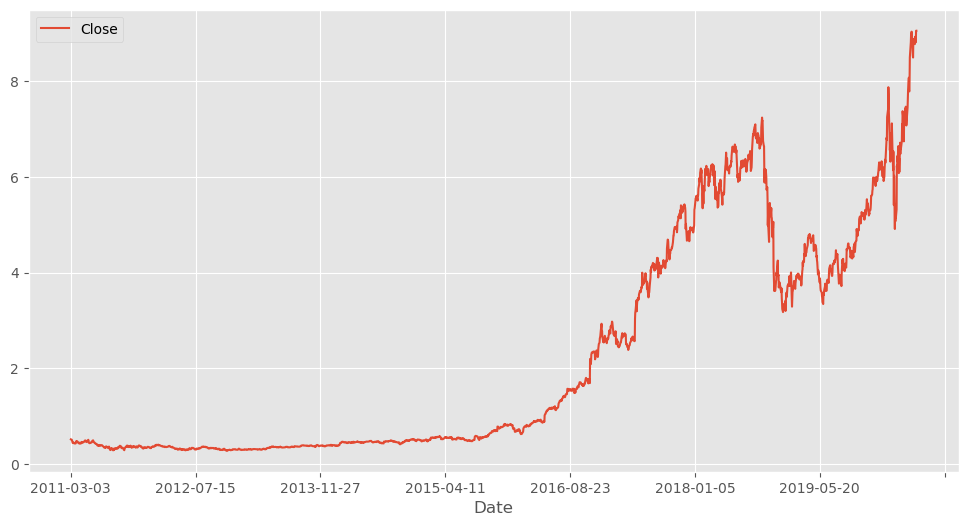

In [39]:
NVDA_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

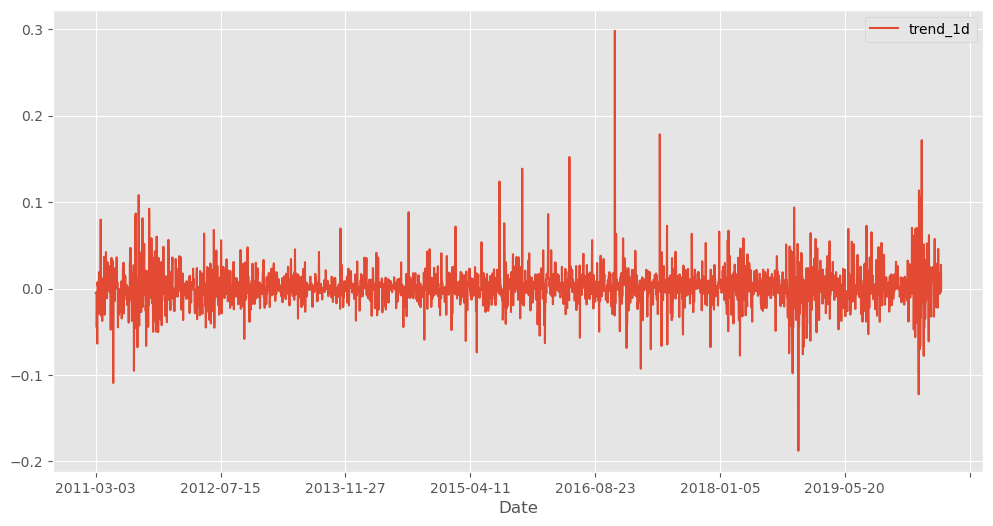

In [40]:
NVDA_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

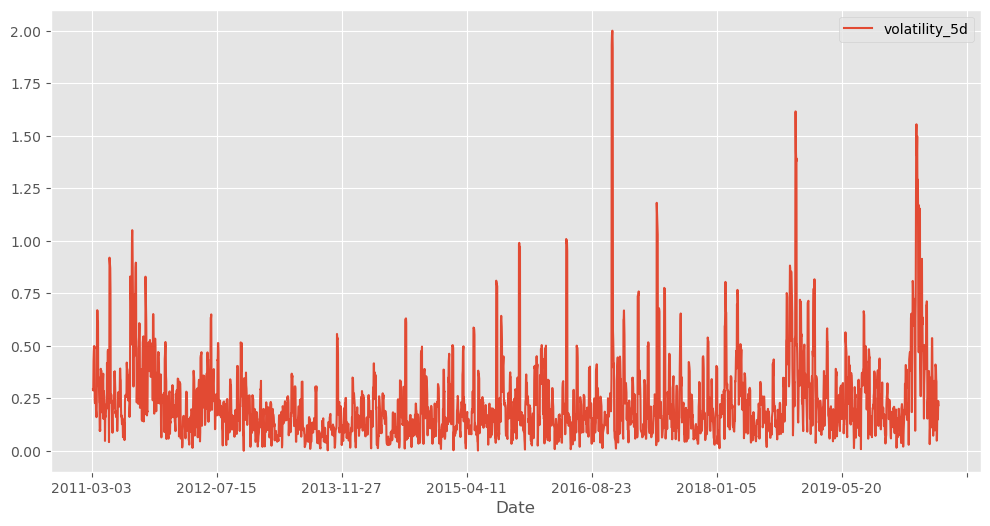

In [41]:
NVDA_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [70]:
NVDA_plot_data = organize_data_for_plot(NVDA_data, resample='W', sentiment_window=28, stock_window=28)

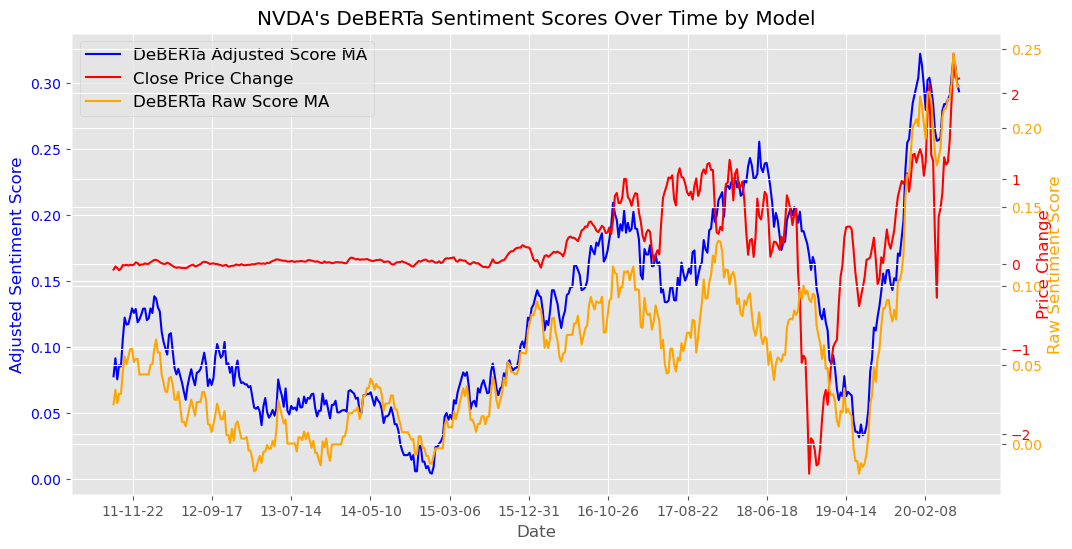

In [74]:
plot_sentiment_and_stock(NVDA_plot_data, 'DeBERTa', 'NVDA', figsize=(12, 6))

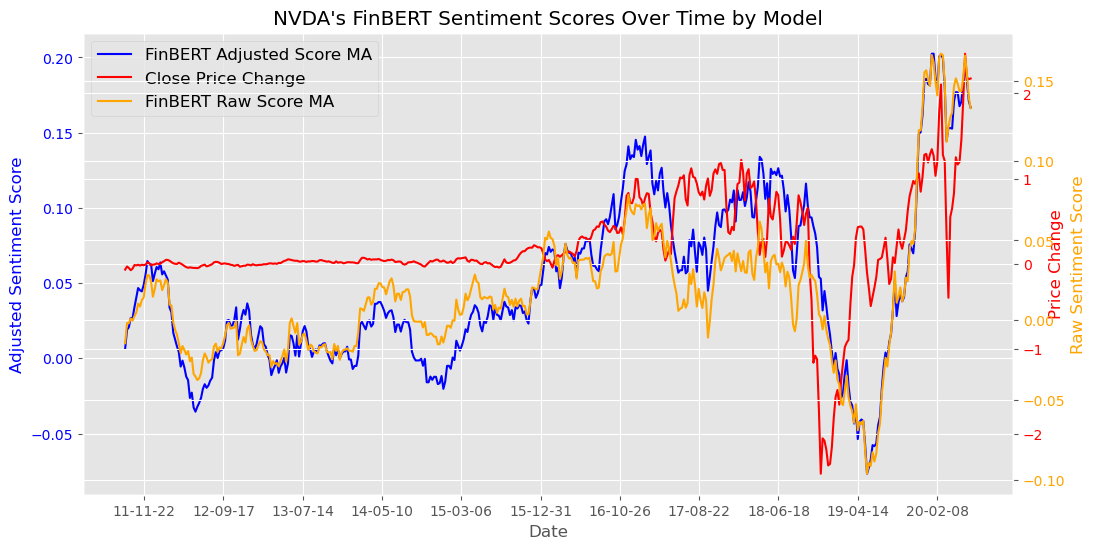

In [75]:
plot_sentiment_and_stock(NVDA_plot_data, 'FinBERT', 'NVDA', figsize=(12, 6))

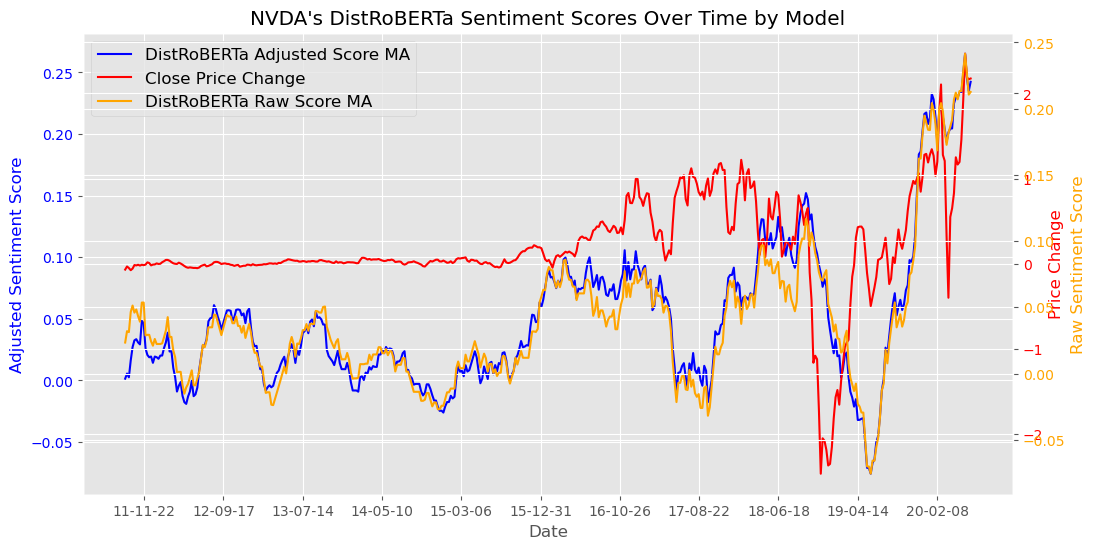

In [76]:
plot_sentiment_and_stock(NVDA_plot_data, 'DistRoBERTa', 'NVDA', figsize=(12, 6))

#### Correlation ####

In [57]:
NVDA_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=5, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.674560   
FinBERT_adjusted_score                    0.674560                1.000000   
DistRoBERTa_adjusted_score                0.664706                0.662323   
trend_1d                                  0.251173                0.211400   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.664706  0.251173  
FinBERT_adjusted_score                        0.662323  0.211400  
DistRoBERTa_adjusted_score                    1.000000  0.193890  
trend_1d                                      0.193890  1.000000

In [58]:
NVDA_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=5, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.714367   
FinBERT_adjusted_score                    0.714367                1.000000   
DistRoBERTa_adjusted_score                0.712472                0.700915   
trend_1d                                  0.268970                0.248902   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.712472  0.268970  
FinBERT_adjusted_score                        0.700915  0.248902  
DistRoBERTa_adjusted_score                    1.000000  0.219772  
trend_1d                                      0.219772  1.000000

In [59]:
NVDA_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=5, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.658564   
FinBERT_raw_score               0.658564           1.000000   
DistRoBERTa_raw_score           0.711824           0.666478   
trend_1d                        0.245146           0.229388   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.711824  0.245146  
FinBERT_raw_score                   0.666478  0.229388  
DistRoBERTa_raw_score               1.000000  0.207533  
trend_1d                            0.207533  1.000000

In [60]:
NVDA_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=5, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.720346   
FinBERT_raw_score               0.720346           1.000000   
DistRoBERTa_raw_score           0.758558           0.721732   
trend_1d                        0.273212           0.268436   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.758558  0.273212  
FinBERT_raw_score                   0.721732  0.268436  
DistRoBERTa_raw_score               1.000000  0.236128  
trend_1d                            0.236128  1.000000

### O

#### Process Data ####

In [91]:
O_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="O")

DeBERTa Accuracy:
Raw: 0.7779661016949152,	Adjusted: 0.7576271186440678
FinBERT Accuracy:
Raw: 0.7779661016949152,	Adjusted: 0.7677966101694915
DistRoBERTa Accuracy:
Raw: 0.7745762711864407,	Adjusted: 0.7677966101694915


#### Plot Data ####

In [78]:
O_data = pd.read_csv("/tmp/pycharm_project_520/src/data/output/O_sentiment.csv")

<Axes: xlabel='Date'>

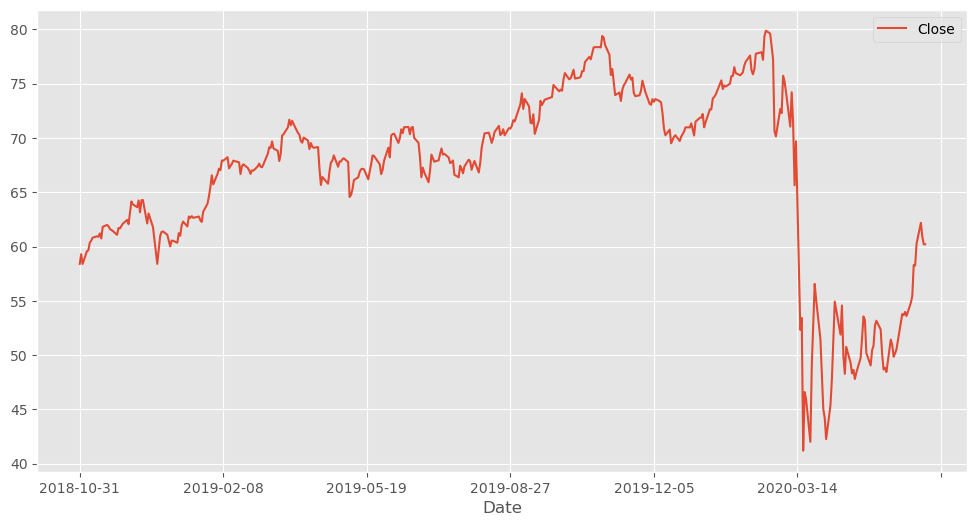

In [79]:
O_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

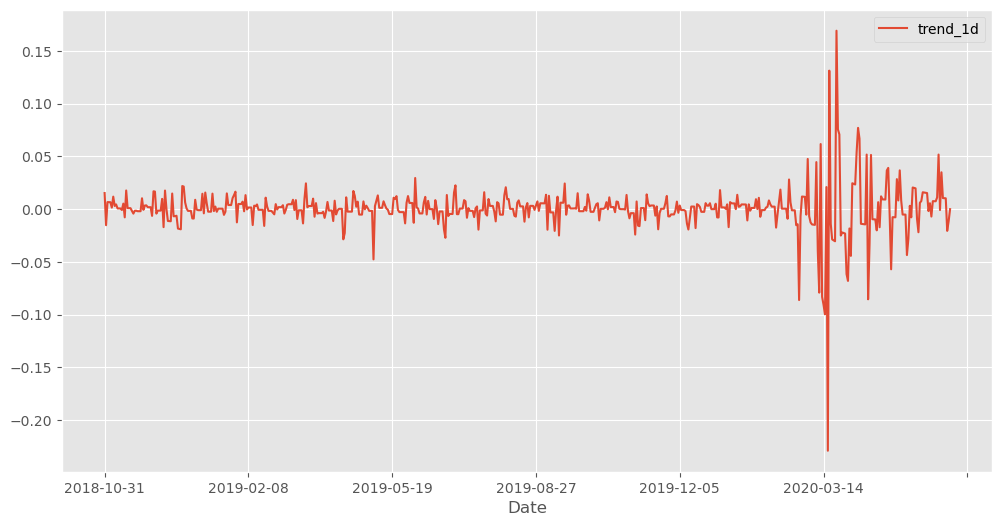

In [80]:
O_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

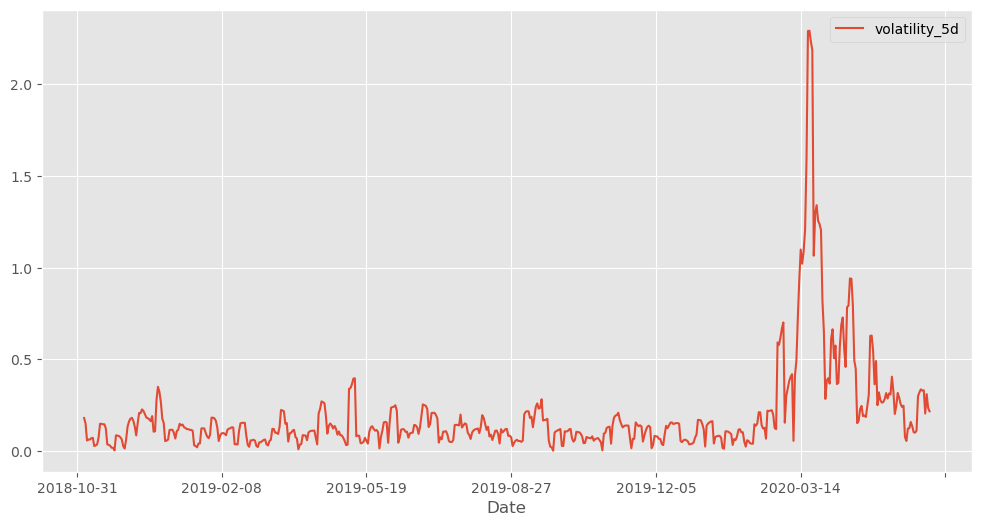

In [81]:
O_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [110]:
O_plot_data = organize_data_for_plot(O_data, resample='D', sentiment_window=28, stock_window=28)

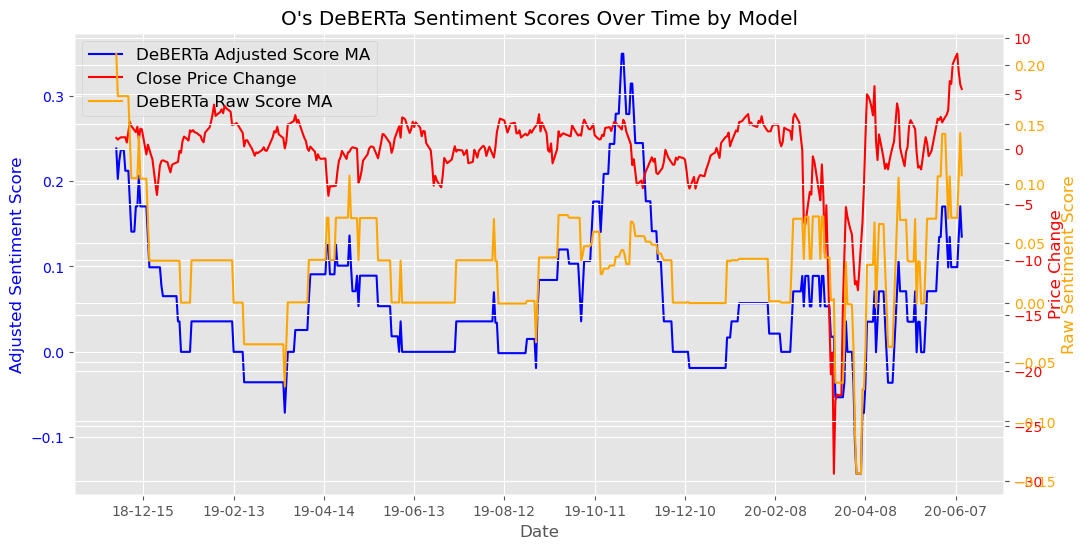

In [111]:
plot_sentiment_and_stock(O_plot_data, 'DeBERTa', 'O')

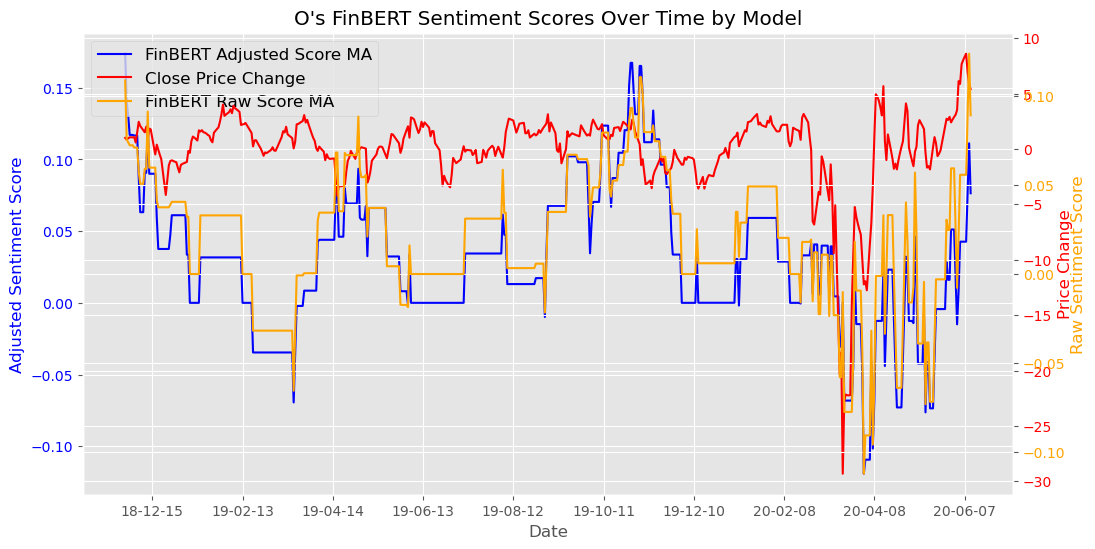

In [112]:
plot_sentiment_and_stock(O_plot_data, 'FinBERT', 'O')

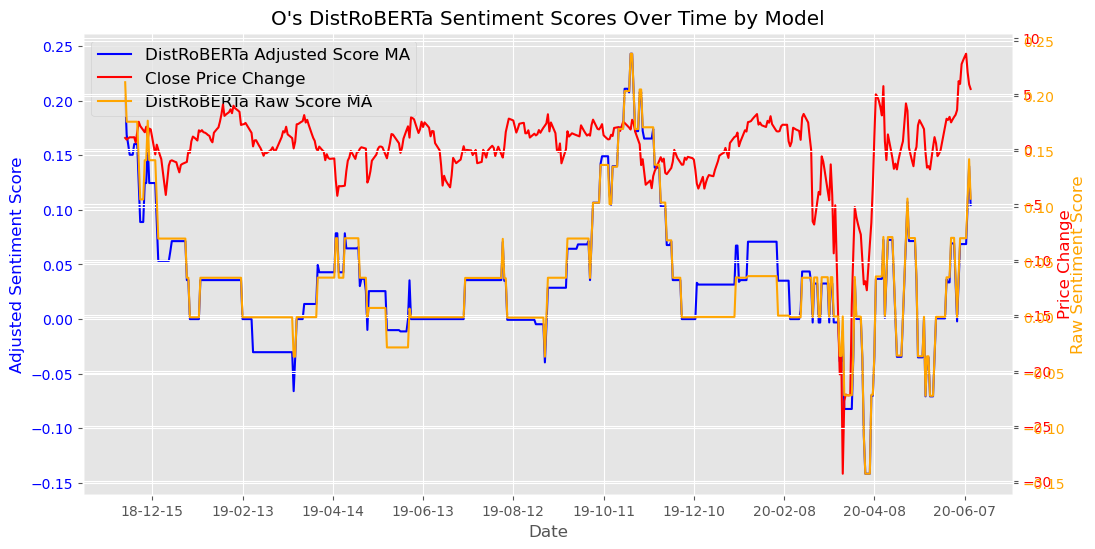

In [113]:
plot_sentiment_and_stock(O_plot_data, 'DistRoBERTa', 'O')

#### Correlation ####

In [114]:
O_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.867456   
FinBERT_adjusted_score                    0.867456                1.000000   
DistRoBERTa_adjusted_score                0.814383                0.815946   
trend_1d                                  0.165678                0.089613   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.814383  0.165678  
FinBERT_adjusted_score                        0.815946  0.089613  
DistRoBERTa_adjusted_score                    1.000000  0.197430  
trend_1d                                      0.197430  1.000000

In [115]:
O_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.884663   
FinBERT_adjusted_score                    0.884663                1.000000   
DistRoBERTa_adjusted_score                0.904944                0.904379   
trend_1d                                  0.289187                0.341853   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.904944  0.289187  
FinBERT_adjusted_score                        0.904379  0.341853  
DistRoBERTa_adjusted_score                    1.000000  0.371443  
trend_1d                                      0.371443  1.000000

In [116]:
O_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.740526   
FinBERT_raw_score               0.740526           1.000000   
DistRoBERTa_raw_score           0.785837           0.872833   
trend_1d                        0.160259           0.139523   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.785837  0.160259  
FinBERT_raw_score                   0.872833  0.139523  
DistRoBERTa_raw_score               1.000000  0.160768  
trend_1d                            0.160768  1.000000

In [117]:
O_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.755047   
FinBERT_raw_score               0.755047           1.000000   
DistRoBERTa_raw_score           0.696268           0.851984   
trend_1d                        0.406772           0.423147   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.696268  0.406772  
FinBERT_raw_score                   0.851984  0.423147  
DistRoBERTa_raw_score               1.000000  0.357258  
trend_1d                            0.357258  1.000000

### MU

#### Process Data ####

In [93]:
MU_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="MU")

DeBERTa Accuracy:
Raw: 0.7047904191616766,	Adjusted: 0.6419161676646706
FinBERT Accuracy:
Raw: 0.7086826347305389,	Adjusted: 0.6754491017964072
DistRoBERTa Accuracy:
Raw: 0.6988023952095809,	Adjusted: 0.6754491017964072


In [ ]:
MU_data = "/tmp/pycharm_project_520/src/data/output/source/MU)sentiment.csv"

#### Plot Data ####

<Axes: xlabel='Date'>

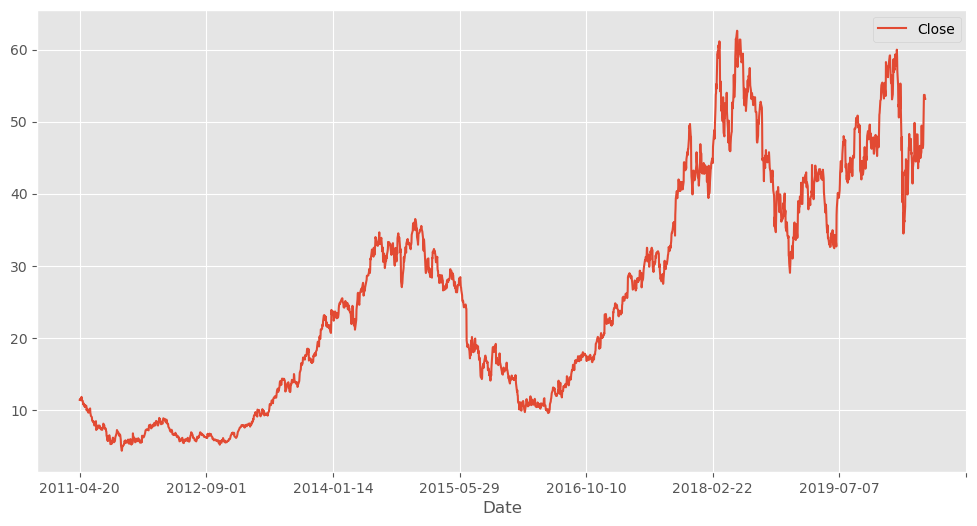

In [134]:
MU_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

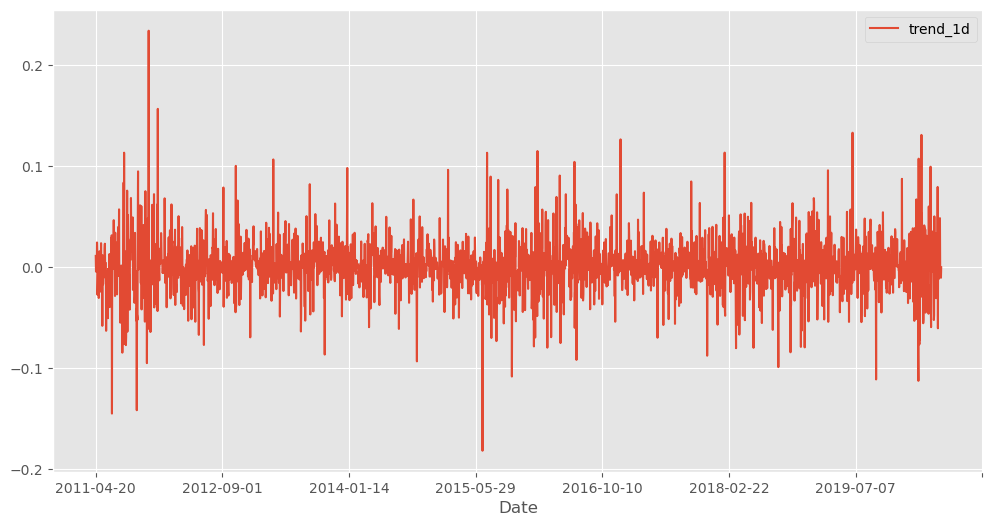

In [135]:
MU_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

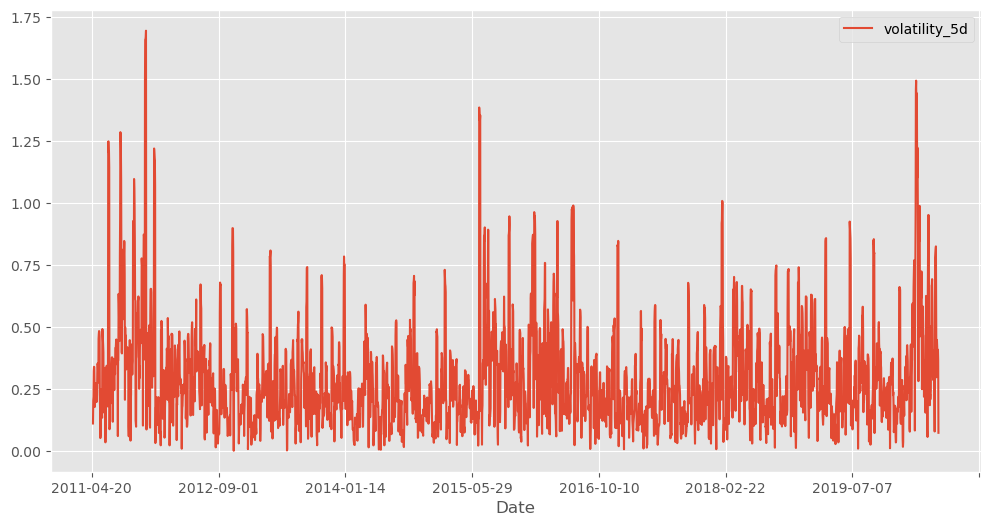

In [136]:
MU_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [125]:
MU_plot_data = organize_data_for_plot(MU_data, resample='W', sentiment_window=28, stock_window=28)

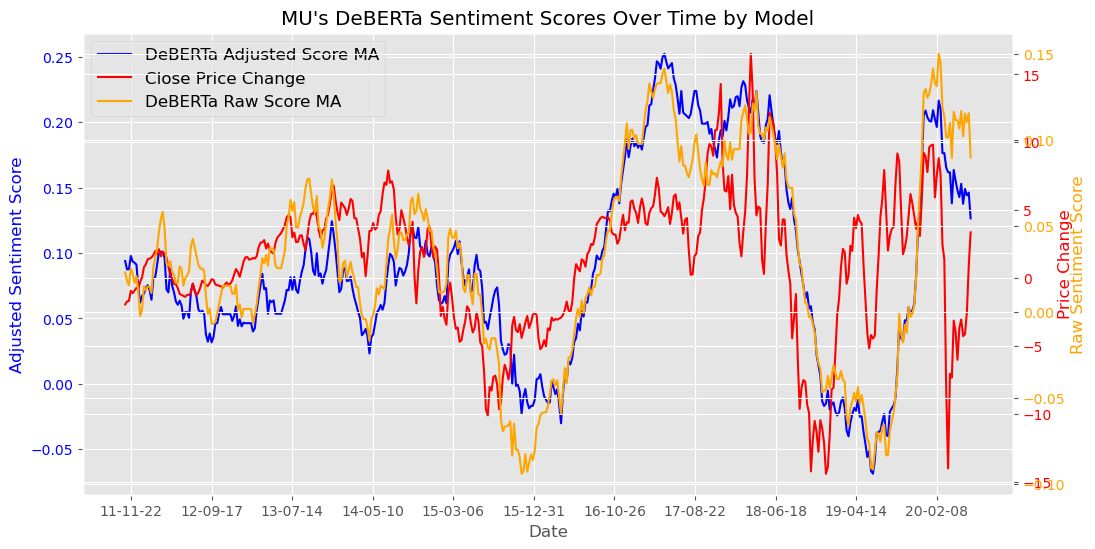

In [126]:
plot_sentiment_and_stock(MU_plot_data, 'DeBERTa', 'MU')

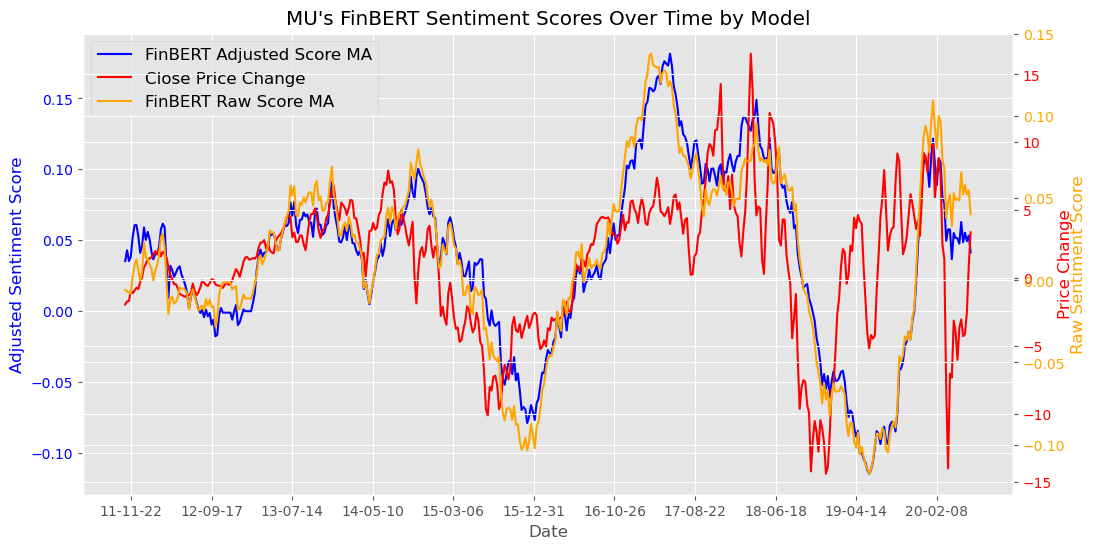

In [127]:
plot_sentiment_and_stock(MU_plot_data, 'FinBERT', 'MU')

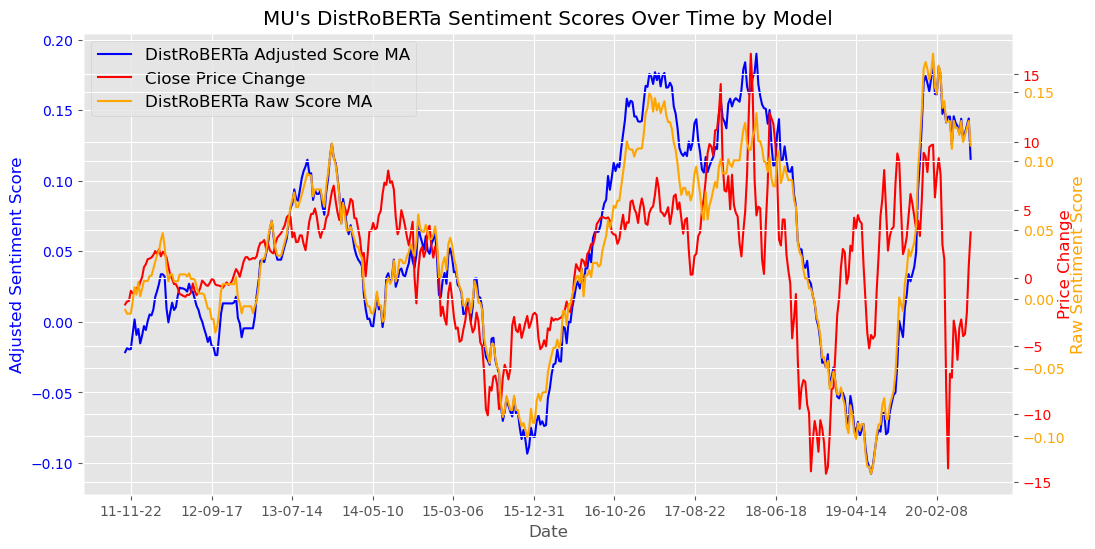

In [128]:
plot_sentiment_and_stock(MU_plot_data, 'DistRoBERTa', 'MU')

#### Correlation ####

In [129]:
MU_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.768633   
FinBERT_adjusted_score                    0.768633                1.000000   
DistRoBERTa_adjusted_score                0.786693                0.796898   
trend_1d                                  0.366608                0.397762   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.786693  0.366608  
FinBERT_adjusted_score                        0.796898  0.397762  
DistRoBERTa_adjusted_score                    1.000000  0.403511  
trend_1d                                      0.403511  1.000000

In [130]:
MU_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.796236   
FinBERT_adjusted_score                    0.796236                1.000000   
DistRoBERTa_adjusted_score                0.815834                0.830909   
trend_1d                                  0.401365                0.426698   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.815834  0.401365  
FinBERT_adjusted_score                        0.830909  0.426698  
DistRoBERTa_adjusted_score                    1.000000  0.432603  
trend_1d                                      0.432603  1.000000

In [131]:
MU_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.812419   
FinBERT_raw_score               0.812419           1.000000   
DistRoBERTa_raw_score           0.835874           0.820639   
trend_1d                        0.439708           0.422728   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.835874  0.439708  
FinBERT_raw_score                   0.820639  0.422728  
DistRoBERTa_raw_score               1.000000  0.427337  
trend_1d                            0.427337  1.000000

In [132]:
MU_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.841371   
FinBERT_raw_score               0.841371           1.000000   
DistRoBERTa_raw_score           0.867780           0.860038   
trend_1d                        0.460437           0.455046   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.867780  0.460437  
FinBERT_raw_score                   0.860038  0.455046  
DistRoBERTa_raw_score               1.000000  0.447778  
trend_1d                            0.447778  1.000000

### MS

#### Process Data ####

In [92]:
MS_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="MS")

DeBERTa Accuracy:
Raw: 0.7241833508956796,	Adjusted: 0.648840885142255
FinBERT Accuracy:
Raw: 0.7289251844046365,	Adjusted: 0.6757112750263435
DistRoBERTa Accuracy:
Raw: 0.7299789251844047,	Adjusted: 0.690200210748156


#### Plot Data ####

<Axes: xlabel='Date'>

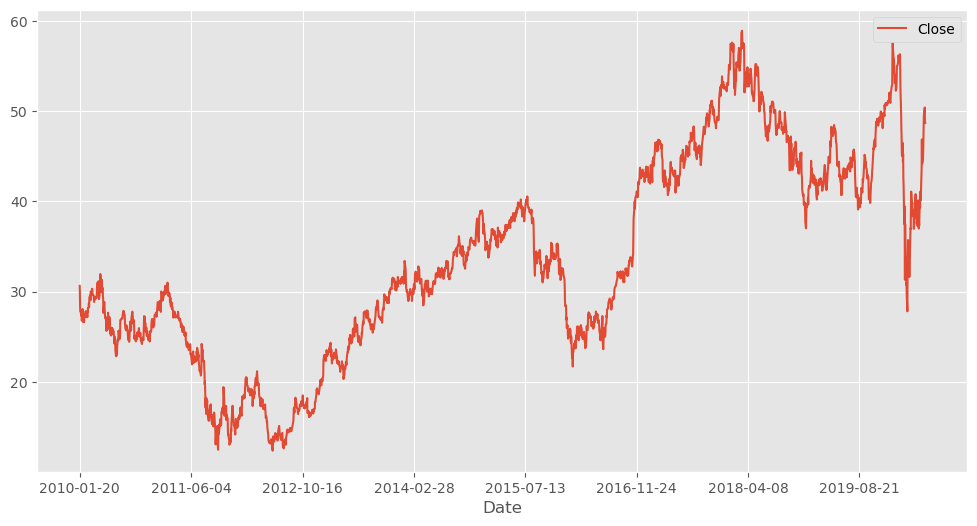

In [137]:
MS_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

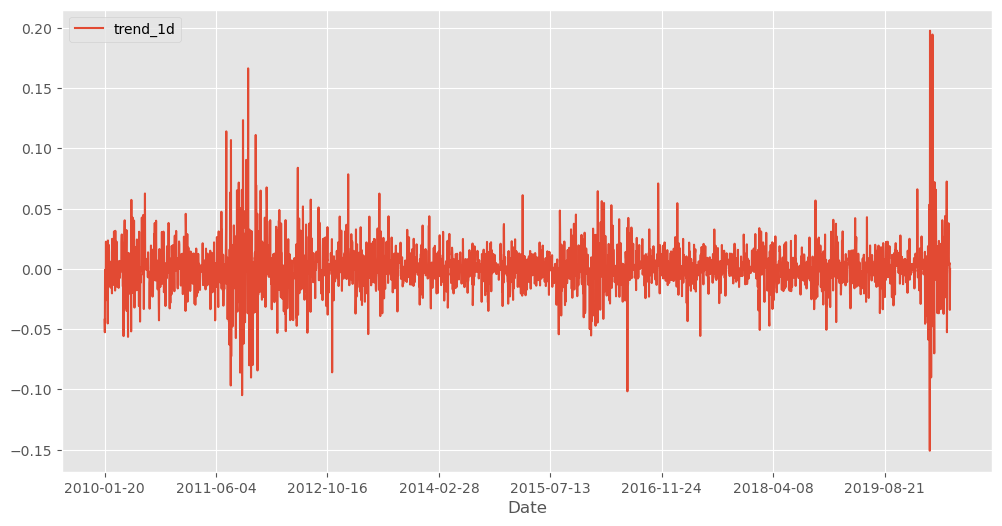

In [138]:
MS_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

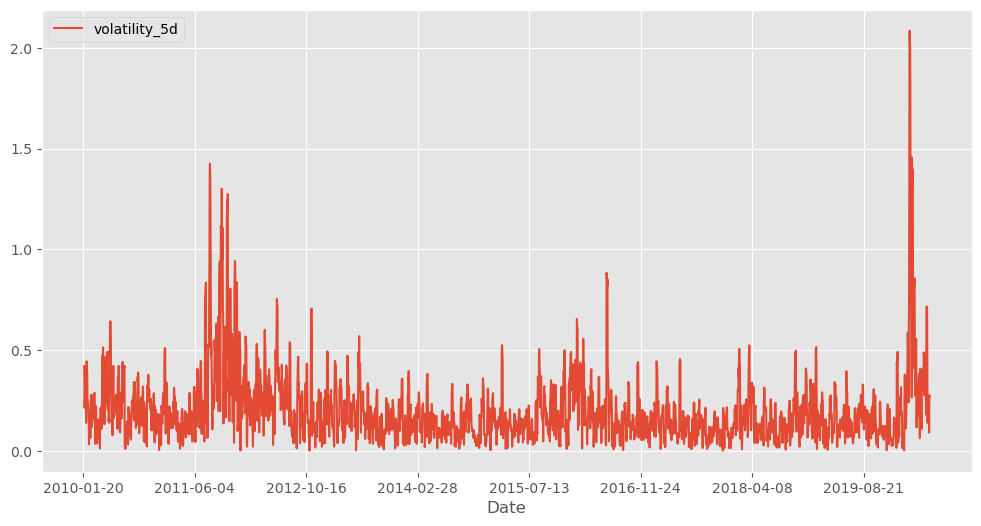

In [139]:
MS_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [140]:
MS_plot_data = organize_data_for_plot(MS_data, resample='W', sentiment_window=28, stock_window=28)

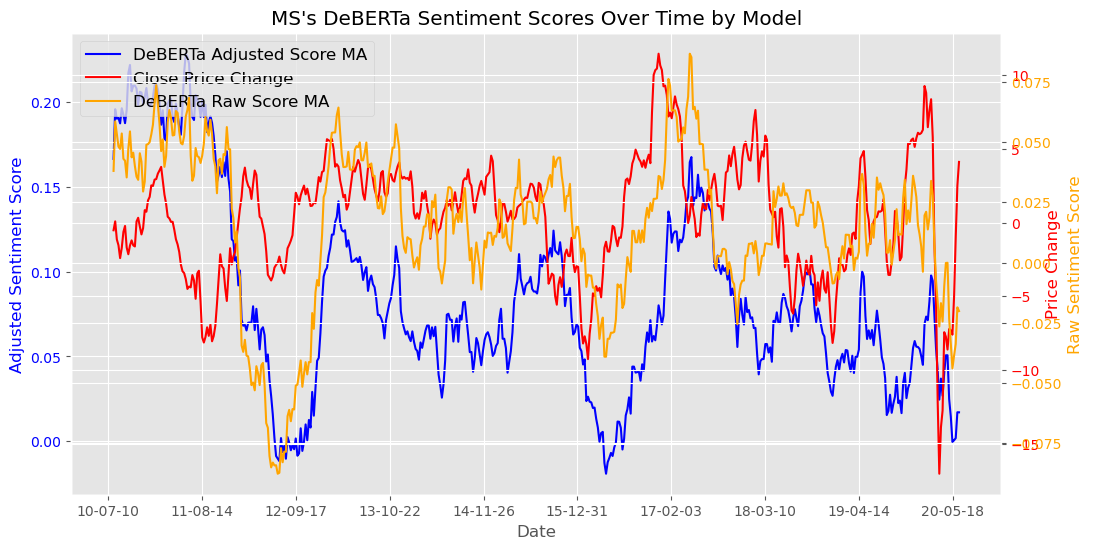

In [141]:
plot_sentiment_and_stock(MS_plot_data, 'DeBERTa', 'MS')

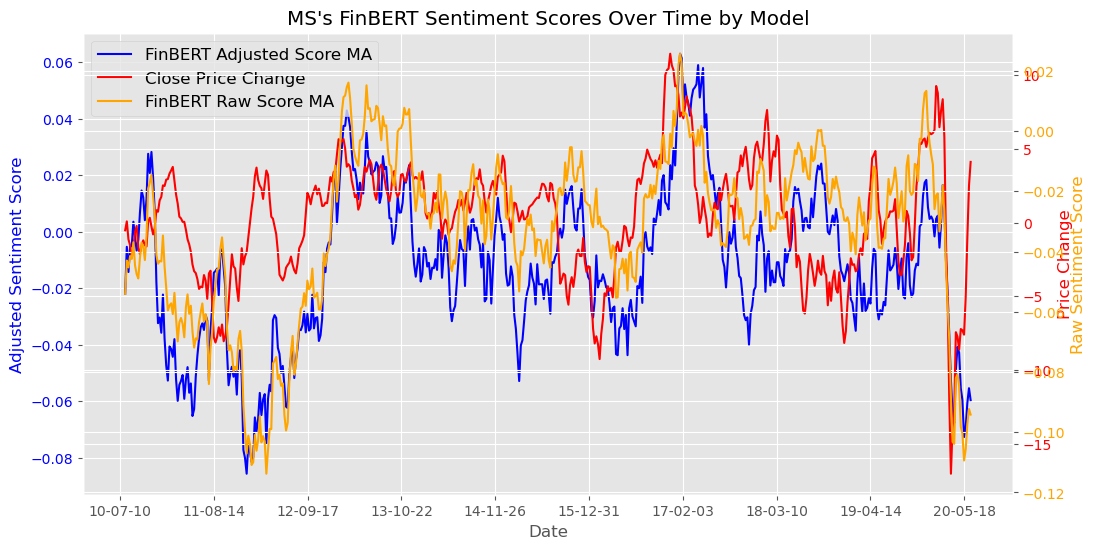

In [142]:
plot_sentiment_and_stock(MS_plot_data, 'FinBERT', 'MS')

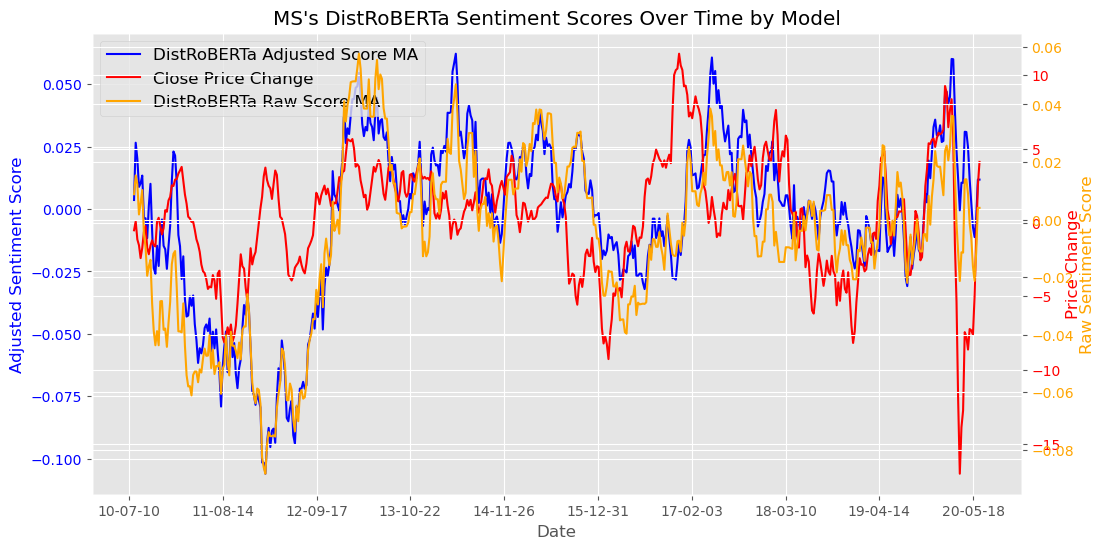

In [143]:
plot_sentiment_and_stock(MS_plot_data, 'DistRoBERTa', 'MS')

#### Correlation ####

In [144]:
MS_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.517427   
FinBERT_adjusted_score                    0.517427                1.000000   
DistRoBERTa_adjusted_score                0.493070                0.554216   
trend_1d                                  0.130704                0.111715   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.493070  0.130704  
FinBERT_adjusted_score                        0.554216  0.111715  
DistRoBERTa_adjusted_score                    1.000000  0.285236  
trend_1d                                      0.285236  1.000000

In [145]:
MS_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.524863   
FinBERT_adjusted_score                    0.524863                1.000000   
DistRoBERTa_adjusted_score                0.510540                0.577860   
trend_1d                                  0.190109                0.195747   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.510540  0.190109  
FinBERT_adjusted_score                        0.577860  0.195747  
DistRoBERTa_adjusted_score                    1.000000  0.337043  
trend_1d                                      0.337043  1.000000

In [146]:
MS_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.560057   
FinBERT_raw_score               0.560057           1.000000   
DistRoBERTa_raw_score           0.628643           0.544669   
trend_1d                        0.188016           0.154700   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.628643  0.188016  
FinBERT_raw_score                   0.544669  0.154700  
DistRoBERTa_raw_score               1.000000  0.289540  
trend_1d                            0.289540  1.000000

In [147]:
MS_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.595026   
FinBERT_raw_score               0.595026           1.000000   
DistRoBERTa_raw_score           0.644752           0.590310   
trend_1d                        0.265770           0.224753   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.644752  0.265770  
FinBERT_raw_score                   0.590310  0.224753  
DistRoBERTa_raw_score               1.000000  0.363501  
trend_1d                            0.363501  1.000000

### GOOG

#### Process Data ####

In [94]:
GOOG_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="GOOG")

DeBERTa Accuracy:
Raw: 0.6180555555555556,	Adjusted: 0.4479166666666667
FinBERT Accuracy:
Raw: 0.5972222222222222,	Adjusted: 0.5017361111111112
DistRoBERTa Accuracy:
Raw: 0.5815972222222222,	Adjusted: 0.5


#### Plot Data ####

<Axes: xlabel='Date'>

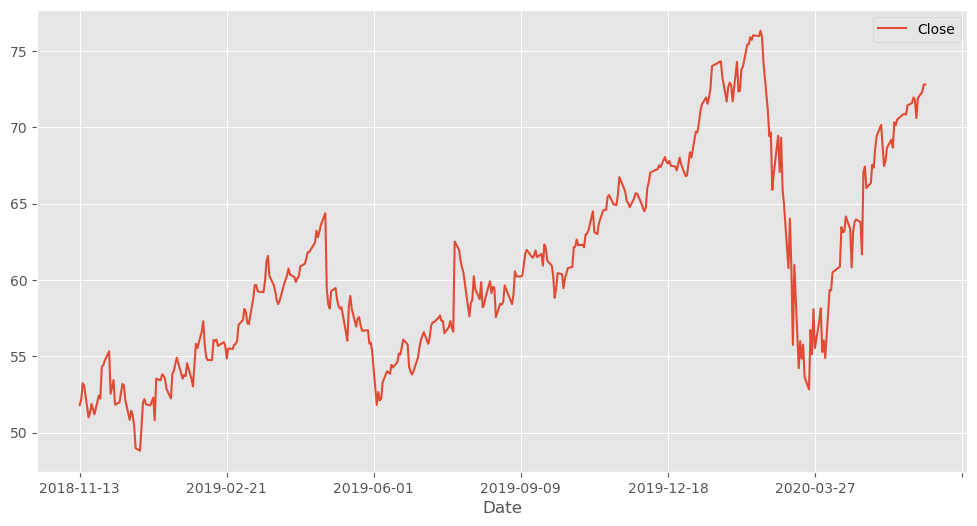

In [148]:
GOOG_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

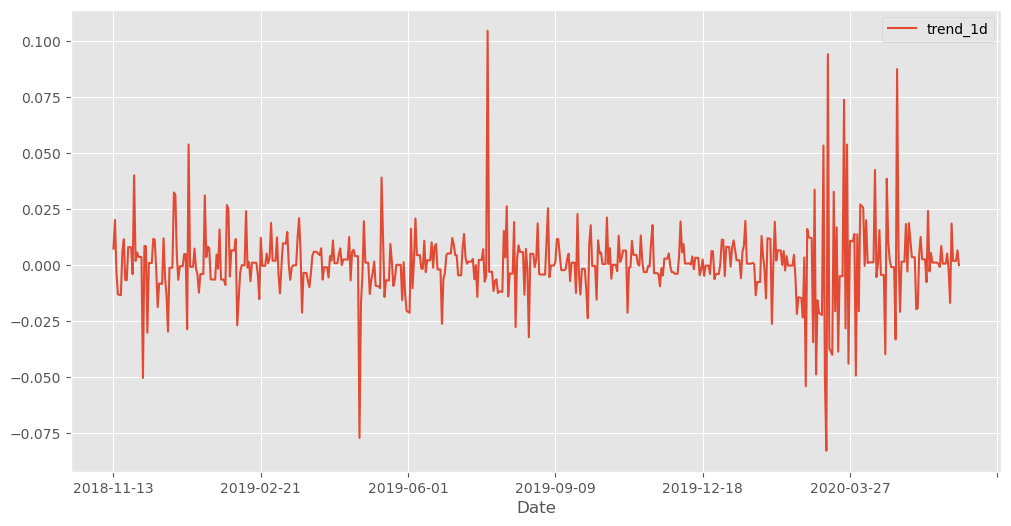

In [149]:
GOOG_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

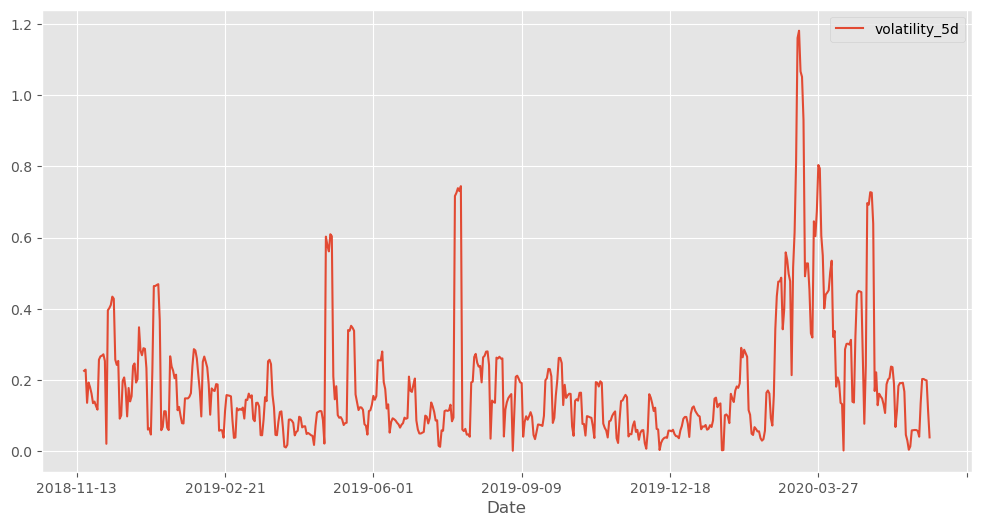

In [150]:
GOOG_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [157]:
GOOG_plot_data = organize_data_for_plot(GOOG_data, resample='B', sentiment_window=21, stock_window=21)

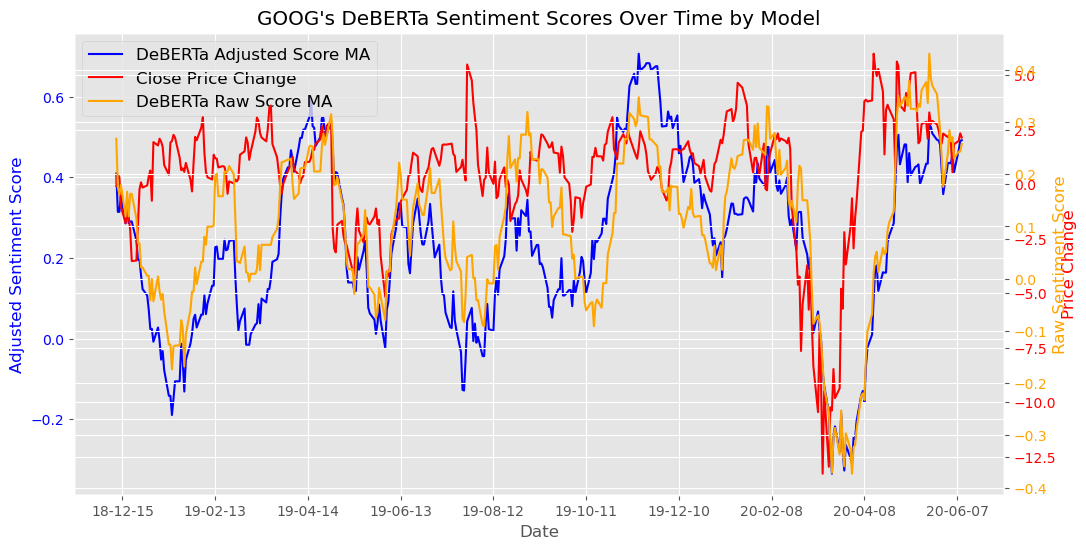

In [158]:
plot_sentiment_and_stock(GOOG_plot_data, 'DeBERTa', 'GOOG')

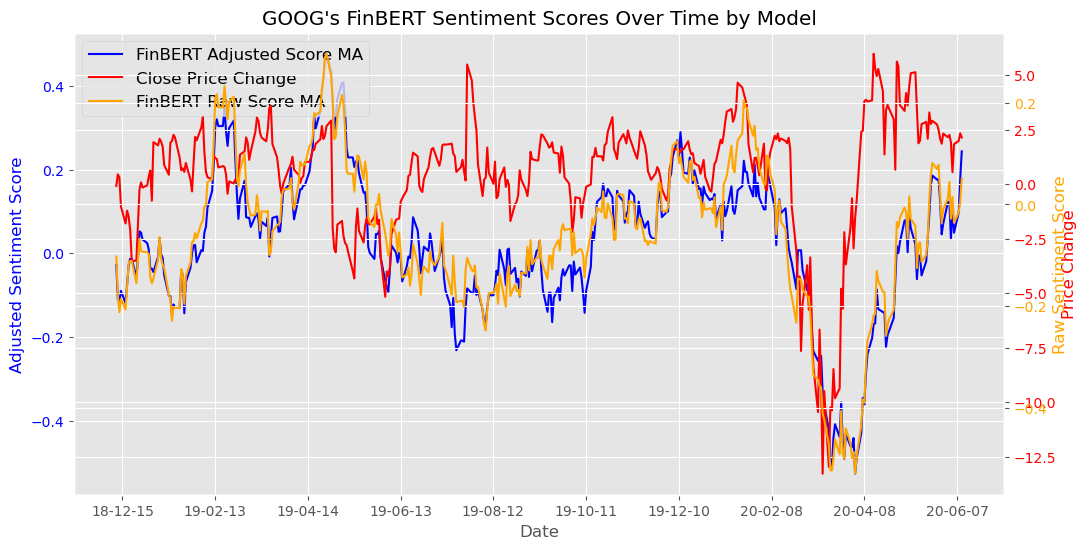

In [159]:
plot_sentiment_and_stock(GOOG_plot_data, 'FinBERT', 'GOOG')

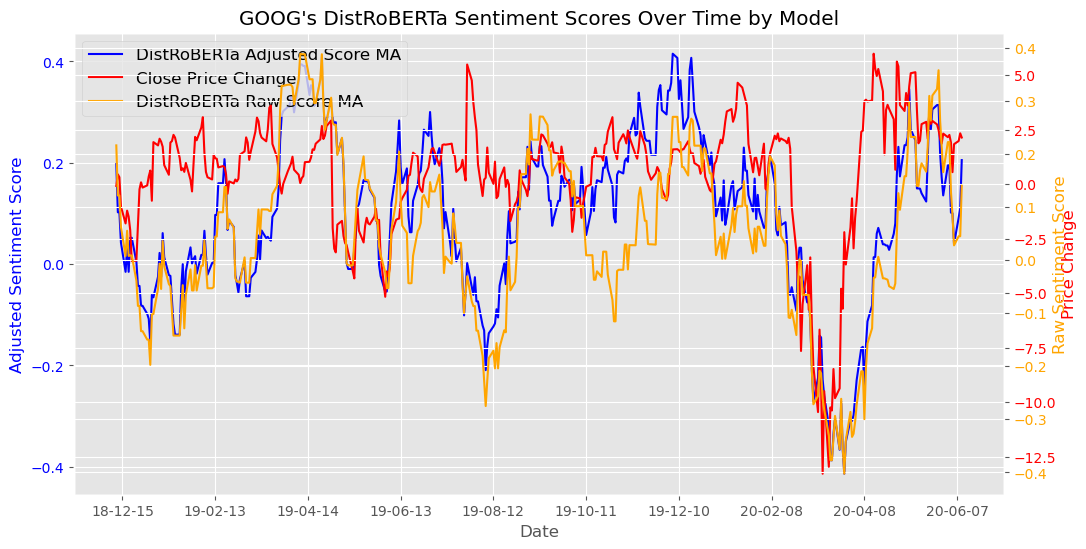

In [160]:
plot_sentiment_and_stock(GOOG_plot_data, 'DistRoBERTa', 'GOOG')

#### Correlation ####

In [161]:
GOOG_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.665227   
FinBERT_adjusted_score                    0.665227                1.000000   
DistRoBERTa_adjusted_score                0.740851                0.566566   
trend_1d                                  0.209073                0.189894   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.740851  0.209073  
FinBERT_adjusted_score                        0.566566  0.189894  
DistRoBERTa_adjusted_score                    1.000000  0.229033  
trend_1d                                      0.229033  1.000000

In [162]:
GOOG_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.706979   
FinBERT_adjusted_score                    0.706979                1.000000   
DistRoBERTa_adjusted_score                0.797877                0.683479   
trend_1d                                  0.398097                0.432980   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.797877  0.398097  
FinBERT_adjusted_score                        0.683479  0.432980  
DistRoBERTa_adjusted_score                    1.000000  0.462086  
trend_1d                                      0.462086  1.000000

In [163]:
GOOG_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.508843   
FinBERT_raw_score               0.508843           1.000000   
DistRoBERTa_raw_score           0.612372           0.544262   
trend_1d                        0.339870           0.247090   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.612372  0.339870  
FinBERT_raw_score                   0.544262  0.247090  
DistRoBERTa_raw_score               1.000000  0.223311  
trend_1d                            0.223311  1.000000

In [164]:
GOOG_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.673883   
FinBERT_raw_score               0.673883           1.000000   
DistRoBERTa_raw_score           0.684830           0.675231   
trend_1d                        0.529835           0.490241   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.684830  0.529835  
FinBERT_raw_score                   0.675231  0.490241  
DistRoBERTa_raw_score               1.000000  0.438262  
trend_1d                            0.438262  1.000000

### MRK

#### Process Data ####

In [95]:
MRK_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="MRK")

DeBERTa Accuracy:
Raw: 0.7060156053360181,	Adjusted: 0.6151522778756607
FinBERT Accuracy:
Raw: 0.7045054115278128,	Adjusted: 0.6337780015101938
DistRoBERTa Accuracy:
Raw: 0.7110495846967028,	Adjusted: 0.6617165869619934


#### Plot Data ####

<Axes: xlabel='Date'>

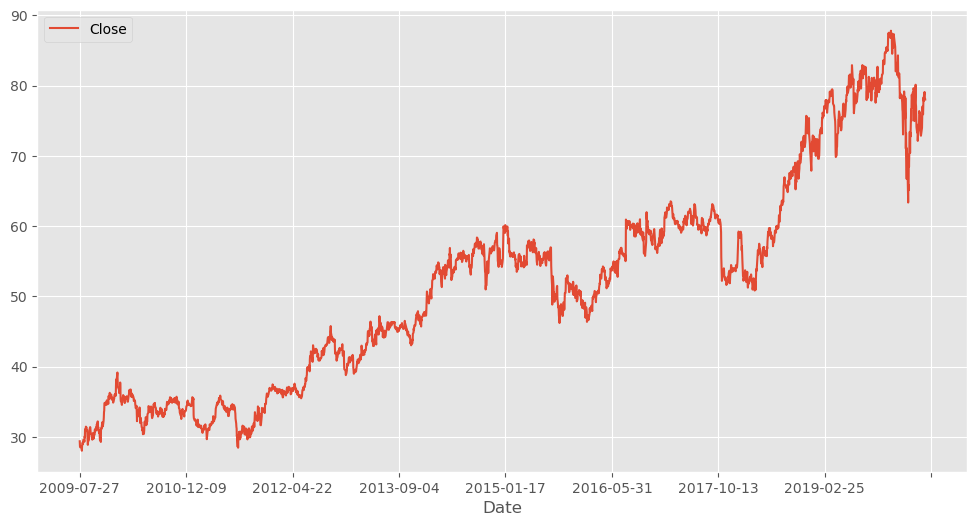

In [165]:
MRK_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

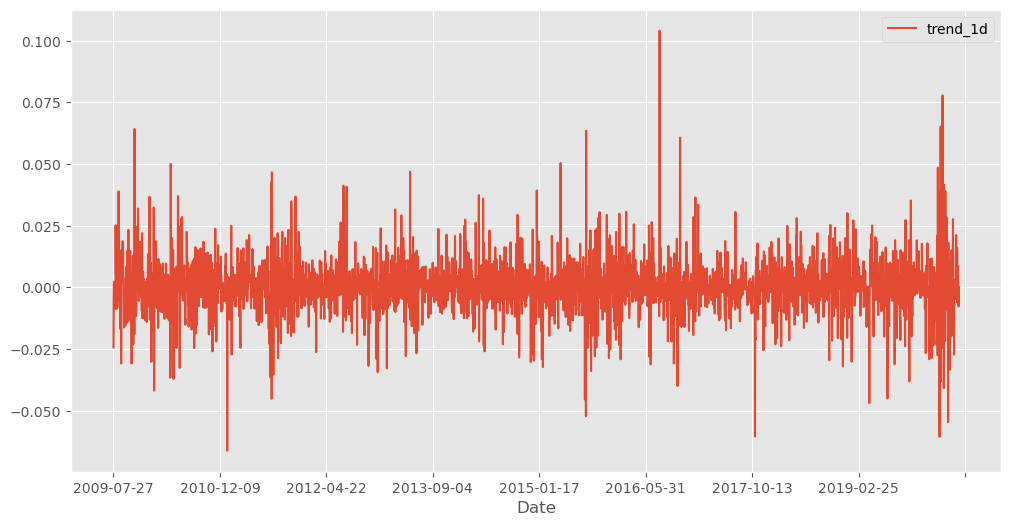

In [166]:
MRK_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

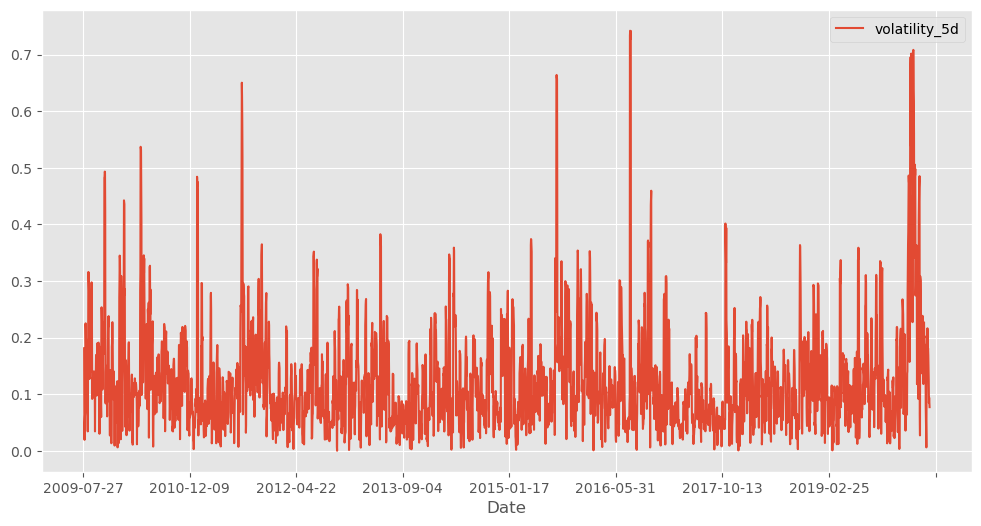

In [167]:
MRK_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [173]:
MRK_plot_data = organize_data_for_plot(MRK_data, resample='W', sentiment_window=28, stock_window=40)

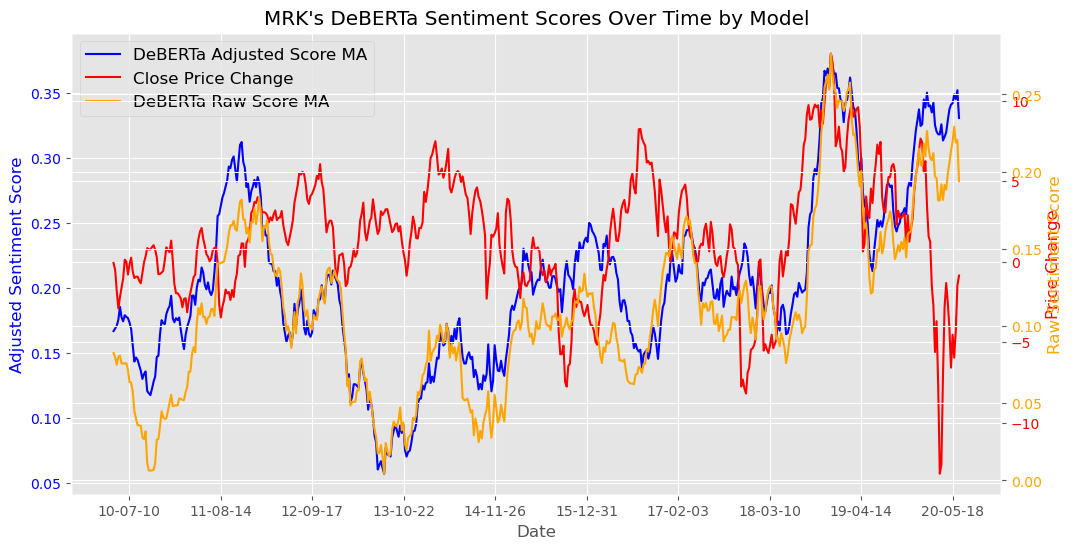

In [174]:
plot_sentiment_and_stock(MRK_plot_data, 'DeBERTa', 'MRK')

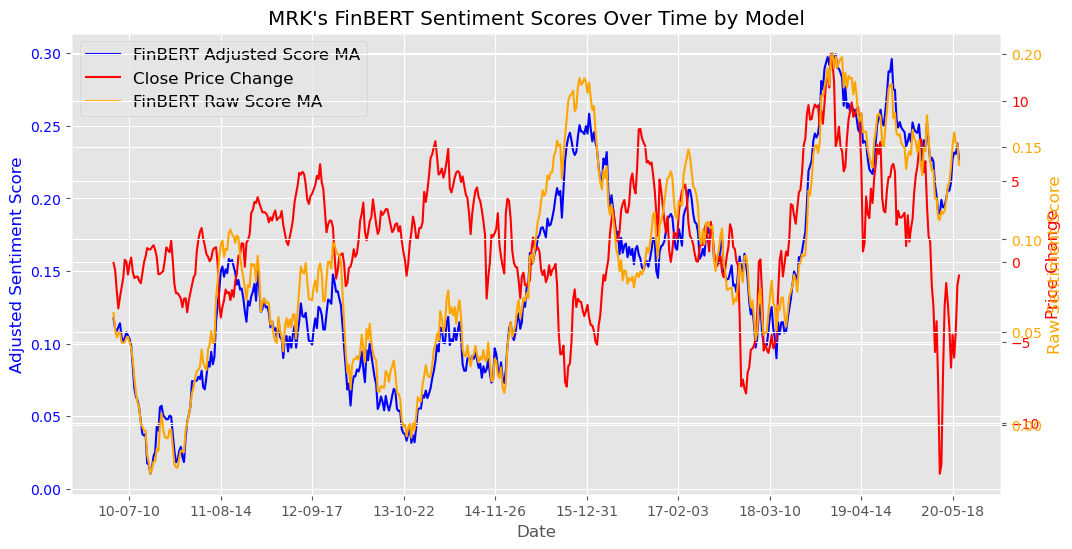

In [175]:
plot_sentiment_and_stock(MRK_plot_data, 'FinBERT', 'MRK')

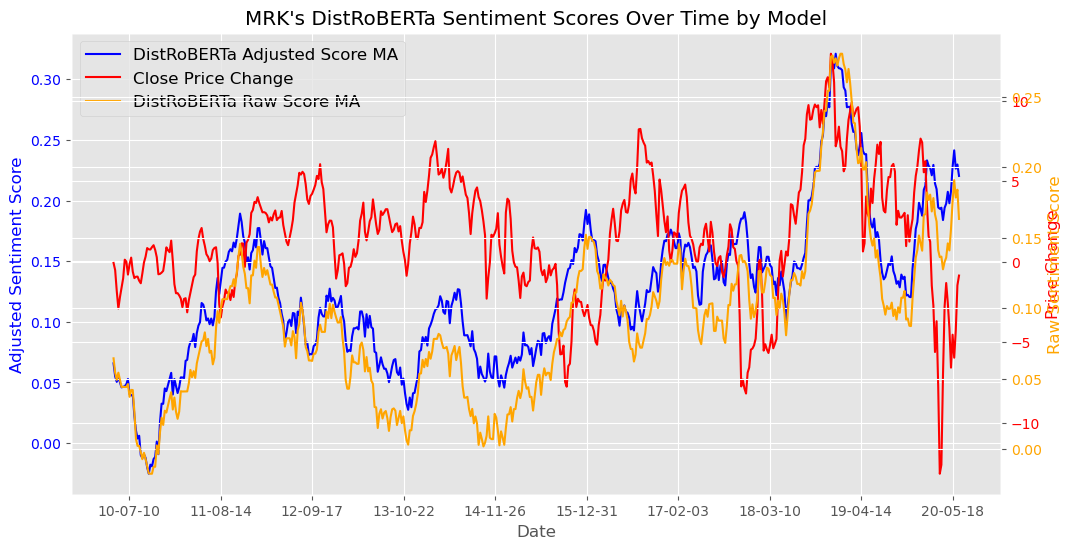

In [176]:
plot_sentiment_and_stock(MRK_plot_data, 'DistRoBERTa', 'MRK')

#### Correlation ####

In [177]:
MRK_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.766867   
FinBERT_adjusted_score                    0.766867                1.000000   
DistRoBERTa_adjusted_score                0.739476                0.731140   
trend_1d                                  0.103567                0.196648   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.739476  0.103567  
FinBERT_adjusted_score                        0.731140  0.196648  
DistRoBERTa_adjusted_score                    1.000000  0.177598  
trend_1d                                      0.177598  1.000000

In [178]:
MRK_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.783949   
FinBERT_adjusted_score                    0.783949                1.000000   
DistRoBERTa_adjusted_score                0.766128                0.748884   
trend_1d                                  0.096176                0.199325   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.766128  0.096176  
FinBERT_adjusted_score                        0.748884  0.199325  
DistRoBERTa_adjusted_score                    1.000000  0.171066  
trend_1d                                      0.171066  1.000000

In [179]:
MRK_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.743766   
FinBERT_raw_score               0.743766           1.000000   
DistRoBERTa_raw_score           0.762519           0.697442   
trend_1d                        0.160081           0.181896   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.762519  0.160081  
FinBERT_raw_score                   0.697442  0.181896  
DistRoBERTa_raw_score               1.000000  0.186940  
trend_1d                            0.186940  1.000000

In [180]:
MRK_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.750247   
FinBERT_raw_score               0.750247           1.000000   
DistRoBERTa_raw_score           0.797483           0.706503   
trend_1d                        0.160639           0.177763   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.797483  0.160639  
FinBERT_raw_score                   0.706503  0.177763  
DistRoBERTa_raw_score               1.000000  0.181156  
trend_1d                            0.181156  1.000000

### QQQ

#### Process Data ####

In [96]:
QQQ_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/analyst_ratings_processed.csv", ticker="QQQ")

DeBERTa Accuracy:
Raw: 0.7883817427385892,	Adjusted: 0.7000592768227623
FinBERT Accuracy:
Raw: 0.7184350918790753,	Adjusted: 0.6926496739774748
DistRoBERTa Accuracy:
Raw: 0.7516301126259632,	Adjusted: 0.6941315945465323


#### Plot Data ####

<Axes: xlabel='Date'>

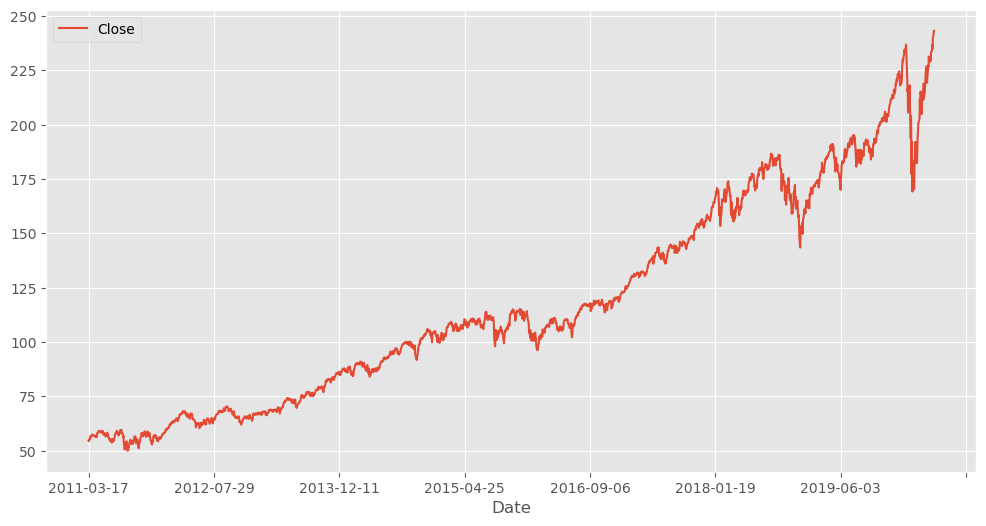

In [181]:
QQQ_data.plot.line(y="Close", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

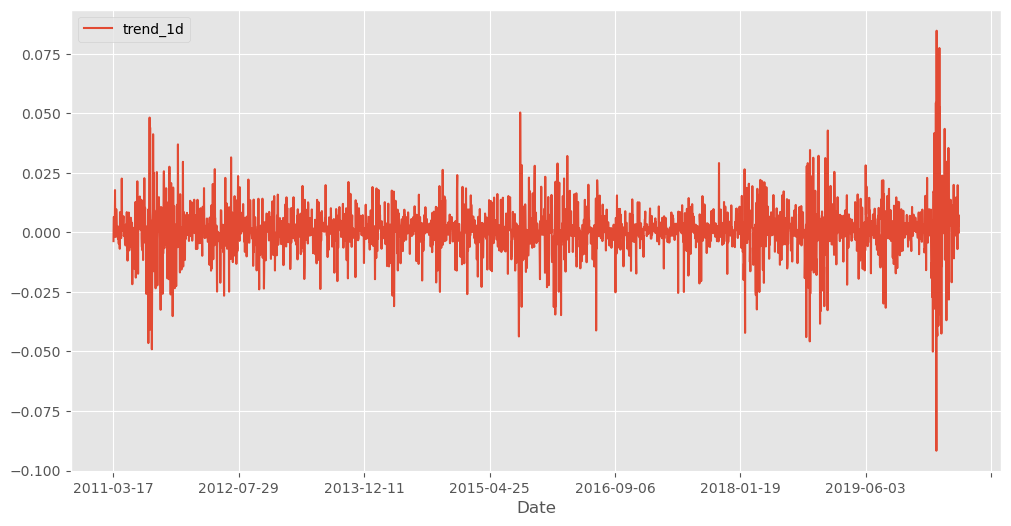

In [182]:
QQQ_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

<Axes: xlabel='Date'>

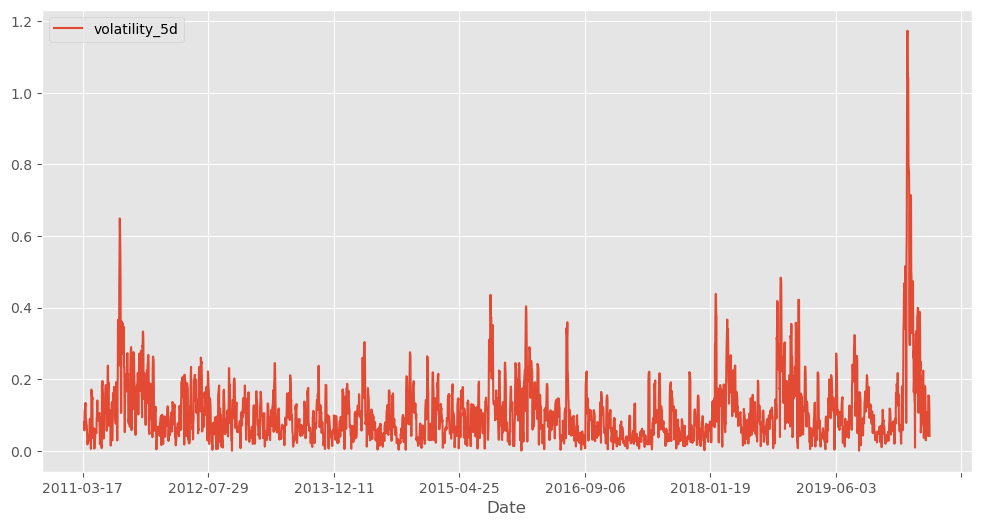

In [183]:
QQQ_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [190]:
QQQ_plot_data = organize_data_for_plot(QQQ_data, resample='W', sentiment_window=28, stock_window=40)

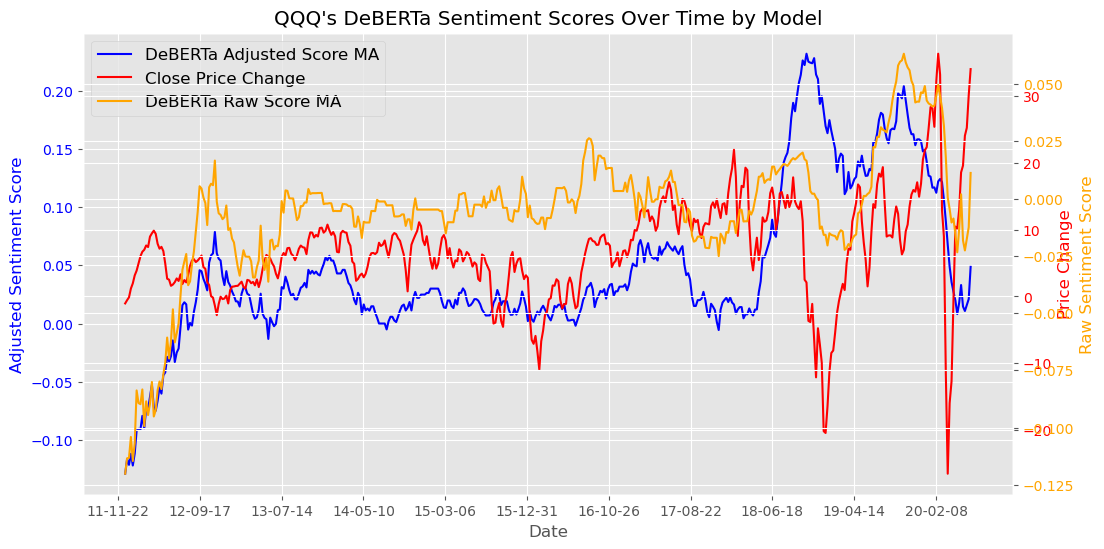

In [191]:
plot_sentiment_and_stock(QQQ_plot_data, 'DeBERTa', 'QQQ')

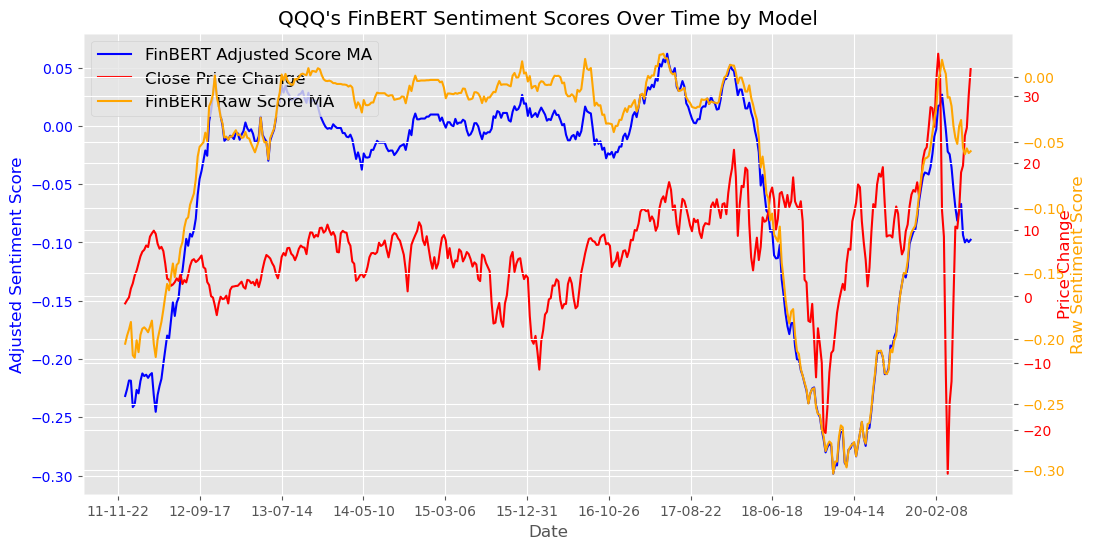

In [192]:
plot_sentiment_and_stock(QQQ_plot_data, 'FinBERT', 'QQQ')

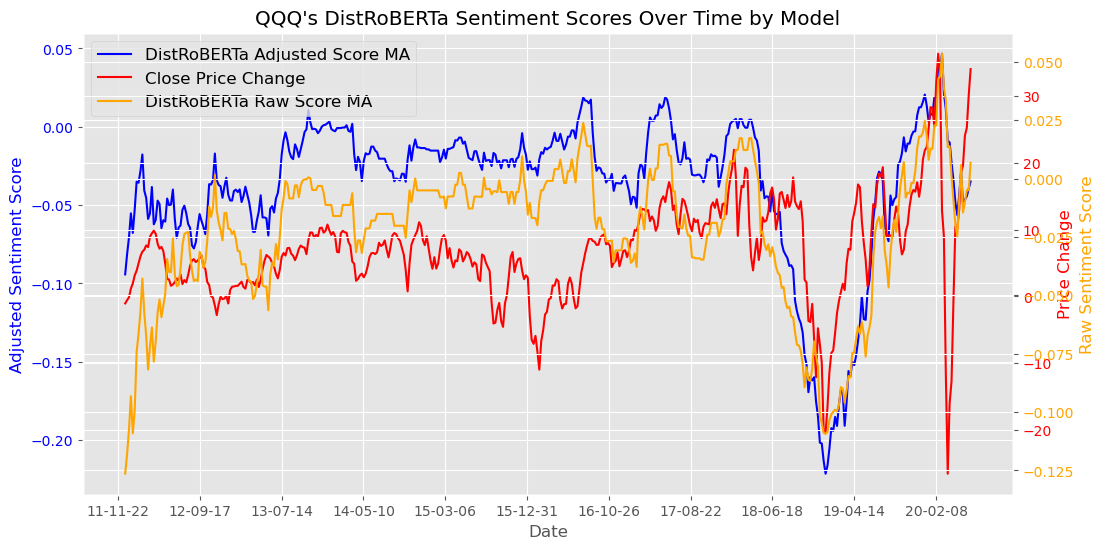

In [193]:
plot_sentiment_and_stock(QQQ_plot_data, 'DistRoBERTa', 'QQQ')

#### Correlation ####

In [194]:
QQQ_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.249303   
FinBERT_adjusted_score                    0.249303                1.000000   
DistRoBERTa_adjusted_score                0.247603                0.606644   
trend_1d                                  0.184575                0.084463   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.247603  0.184575  
FinBERT_adjusted_score                        0.606644  0.084463  
DistRoBERTa_adjusted_score                    1.000000  0.276439  
trend_1d                                      0.276439  1.000000

In [195]:
QQQ_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_adjusted_score  FinBERT_adjusted_score  \
DeBERTa_adjusted_score                    1.000000                0.202493   
FinBERT_adjusted_score                    0.202493                1.000000   
DistRoBERTa_adjusted_score                0.252027                0.665985   
trend_1d                                  0.222063                0.142152   

                            DistRoBERTa_adjusted_score  trend_1d  
DeBERTa_adjusted_score                        0.252027  0.222063  
FinBERT_adjusted_score                        0.665985  0.142152  
DistRoBERTa_adjusted_score                    1.000000  0.284084  
trend_1d                                      0.284084  1.000000

In [196]:
QQQ_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.440675   
FinBERT_raw_score               0.440675           1.000000   
DistRoBERTa_raw_score           0.552021           0.636699   
trend_1d                        0.184815           0.124059   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.552021  0.184815  
FinBERT_raw_score                   0.636699  0.124059  
DistRoBERTa_raw_score               1.000000  0.257566  
trend_1d                            0.257566  1.000000

In [197]:
QQQ_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

DeBERTa_raw_score  FinBERT_raw_score  \
DeBERTa_raw_score               1.000000           0.452189   
FinBERT_raw_score               0.452189           1.000000   
DistRoBERTa_raw_score           0.592216           0.613909   
trend_1d                        0.237208           0.157777   

                       DistRoBERTa_raw_score  trend_1d  
DeBERTa_raw_score                   0.592216  0.237208  
FinBERT_raw_score                   0.613909  0.157777  
DistRoBERTa_raw_score               1.000000  0.237051  
trend_1d                            0.237051  1.000000

### MSFT

#### Process Data ####

In [97]:
MSFT_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/MicrosoftNews.csv", ticker="MSFT")

DeBERTa Accuracy:
Raw: 0.7563646318094717,	Adjusted: 0.6539830276485081
FinBERT Accuracy:
Raw: 0.7489734464823433,	Adjusted: 0.6665754174650972
DistRoBERTa Accuracy:
Raw: 0.7109225294278675,	Adjusted: 0.6515192992061319


#### Plot Data ####

In [ ]:
MSFT_data.plot.line(y="Close", x='Date', figsize=(12, 6))

In [ ]:
MSFT_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

In [ ]:
MSFT_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [ ]:
MSFT_plot_data = organize_data_for_plot(MSFT_data, resample='D', sentiment_window=3, stock_window=3)

In [ ]:
plot_sentiment_and_stock(MSFT_plot_data, 'DeBERTa', 'MSFT')

In [ ]:
plot_sentiment_and_stock(MSFT_plot_data, 'FinBERT', 'MSFT')

In [ ]:
plot_sentiment_and_stock(MSFT_plot_data, 'DistRoBERTa', 'MSFT')

#### Correlation ####

In [ ]:
MSFT_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

In [ ]:
MSFT_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

In [ ]:
MSFT_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

In [ ]:
MSFT_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

### AAPL

#### Process Data ####

In [99]:
AAPL_data = process_data("/tmp/pycharm_project_520/src/data/input/raw/source/AppleNews.csv", ticker="AAPL")

DeBERTa Accuracy:
Raw: 0.7623870791130578,	Adjusted: 0.5745962222830551
FinBERT Accuracy:
Raw: 0.7812756638379414,	Adjusted: 0.6271557623870792
DistRoBERTa Accuracy:
Raw: 0.5967697782644402,	Adjusted: 0.48617574596222285


#### Plot Data ####

In [ ]:
AAPL_data.plot.line(y="Close", x='Date', figsize=(12, 6))

In [ ]:
AAPL_data.plot.line(y="trend_1d", x='Date', figsize=(12, 6))

In [ ]:
AAPL_data.plot.line(y="volatility_5d", x='Date', figsize=(12, 6))

In [ ]:
AAPL_plot_data = organize_data_for_plot(AAPL_data, resample='D', sentiment_window=3, stock_window=3)

In [ ]:
plot_sentiment_and_stock(AAPL_plot_data, 'DeBERTa', 'AAPL')

In [ ]:
plot_sentiment_and_stock(AAPL_plot_data, 'FinBERT', 'AAPL')

In [ ]:
plot_sentiment_and_stock(AAPL_plot_data, 'DistRoBERTa', 'AAPL')

#### Correlation ####

In [ ]:
AAPL_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

In [ ]:
AAPL_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

In [ ]:
AAPL_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

In [ ]:
AAPL_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

## Visszatesztelés

In [ ]:
MU_data = pd.read_csv('/tmp/pycharm_project_520/src/data/output/MU_sentiment.csv')

In [ ]:
results, cerebro = run_backtest(MS_data, 'DeBERTa', 'adjusted', window=30, resample='D')

In [ ]:
fig = plot_backtest(cerebro)
plt.show()

# Összefoglalás

# Summary

# Irodalomjegyzék